# Replication of Carneiro, Heckman, & Vytlacil's (2011) *Local Instrumental Variables* approach

In this notebook, I reproduce the semiparametric results from

> Carneiro, P., Heckman, J. J., & Vytlacil, E. J. (2011). [Estimating marginal returns to education.](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.101.6.2754) *American Economic Review, 101*(6), 2754-81. 

The goal of this endeavor is to add the semiparametric estimation method to the open-source package *grmpy* for the simulation and estimation of the generalized Roy model in Python. Currently, *grmpy* is limited to the estimation of a parametric normal version of the generalized Roy model. <br> For more, see the [online documentation](https://grmpy.readthedocs.io/en/develop/). 

This notebook makes use of the replication material provided by [Carneiro et al. (2011)](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.101.6.2754).

In [1]:
import pandas as pd
import numpy as np
import warnings
import math

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from grmpy.check.check import check_presence_estimation_dataset
from grmpy.check.check import check_initialization_dict
from grmpy.check.check import check_presence_init
from grmpy.check.auxiliary import read_data
from grmpy.read.read import read

from semipar.estimation.estimate_auxiliary import estimate_treatment_propensity
from semipar.estimation.estimate_auxiliary import define_common_support
from semipar.estimation.estimate_auxiliary import double_residual_reg
from semipar.estimation.estimate_auxiliary import construct_Xp
from semipar.estimation.estimate_auxiliary import trim_data

from semipar.estimation.estimate import semipar_fit
from semipar.KernReg.locpoly import locpoly
from hackathon_auxiliary import bootstrap
from sklearn.utils import resample
from scipy.stats import norm

warnings.filterwarnings('ignore')

Since the replication material does not contain geographic identifiers, we are unable to merge the separate data files in such a way to accurately recreate the original data set. Therefore, we need to create a mock data set where indivudal specific data and local characteristics are merged arbitrarily (note, however, that the basic and local data are merged the same way each time, so we always work with the same mock data set).

In [2]:
# Data preparation
def process_mock_df(df, output_file):
    """This function adds squared and interaction terms to the Carneiro data set."""

    # Delete redundant columns\n",
    for key_ in ["newid", "caseid"]:
        del df[key_]

    # Add squared terms
    for key_ in ["mhgc", "cafqt", "avurate", "lurate_17", "numsibs", "lavlocwage17"]:
        str_ = key_ + "sq"
        df[str_] = df[key_] ** 2

    # Add interaction terms
    for j in ["pub4", "lwage5_17", "lurate_17", "tuit4c"]:
        for i in ["cafqt", "mhgc", "numsibs"]:
            df[j + i] = df[j] * df[i]
    
    # save output_file
    df.to_pickle(output_file + ".pkl")

In [3]:
basic = pd.read_stata('semipar/data/basicvariables.dta')
local = pd.read_stata('semipar/data/localvariables.dta')
df = pd.concat([basic, local], axis = 1)
process_mock_df(df,'semipar/data/aer-replication-mock')

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1747
Model:                          Logit   Df Residuals:                     1717
Method:                           MLE   Df Model:                           29
Date:                Fri, 29 Nov 2019   Pseudo R-squ.:                  0.2858
Time:                        21:09:16   Log-Likelihood:                -864.74
converged:                       True   LL-Null:                       -1210.8
                                        LLR p-value:                4.178e-127
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              288.3699    151.012      1.910      0.056      -7.609     584.349
cafqt               -6.4256      5.019     -1.280      0.200     -16.263       3.411
cafqtsq              0.3348 

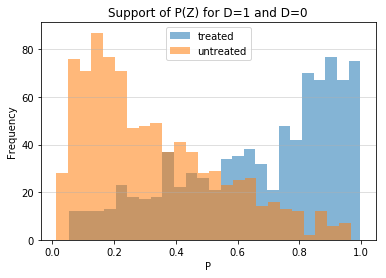

In [4]:
# Replicate the results from Carneiro et al. (2011) using the mock data set created above.
quantiles, mte_u, X, b1_b0 = semipar_fit("semipar/files/replication.bootstrap.yml")

# Calculate the MTE component that depends on X
mte_x = np.dot(X, b1_b0).mean(axis=0)

# Put the MTE together
mte = mte_x + mte_u

# Note that the MTE is divided by 4 to get an estimate of the benefits of one 
# additional year of college education rather than the benefits of obtaining a 4-year college degree.
mte_4 = mte / 4

In [5]:
# Accounting for variation in X
mte_x = np.dot(X, b1_b0)

mte_min = np.min(mte_x) + mte_u
mte_max = np.max(mte_x) + mte_u

mte_4_min = mte_min / 4
mte_4_max = mte_max / 4

print(np.min(mte_4_min))
print(np.max(mte_4_max))

-0.5703098725430777
0.642057689504167


Following Carneiro et al. (2011), I compute 90 percent confidence intervals using bootstrapped standard errors (250 iterations). 

First, draw $B = 250$ independent bootstrap samples and compute the *MTE* $ \ \hat{\theta}^{MTE}(b)$ for each bootstrap replication $b = 1,..,B$. 

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1747
Model:                          Logit   Df Residuals:                     1717
Method:                           MLE   Df Model:                           29
Date:                Fri, 29 Nov 2019   Pseudo R-squ.:                  0.2926
Time:                        21:09:20   Log-Likelihood:                -856.51
converged:                       True   LL-Null:                       -1210.8
                                        LLR p-value:                1.638e-130
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              311.0500    157.942      1.969      0.049       1.489     620.611
cafqt              -12.7598      5.265     -2.423      0.015     -23.080      -2.440
cafqtsq              0.4040 

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1747
Model:                          Logit   Df Residuals:                     1716
Method:                           MLE   Df Model:                           30
Date:                Fri, 29 Nov 2019   Pseudo R-squ.:                  0.3332
Time:                        21:09:20   Log-Likelihood:                -807.22
converged:                       True   LL-Null:                       -1210.6
                                        LLR p-value:                2.312e-150
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              557.2927    166.325      3.351      0.001     231.302     883.284
cafqt               -7.9205      5.560     -1.425      0.154     -18.817       2.976
cafqtsq              0.2902 

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1747
Model:                          Logit   Df Residuals:                     1717
Method:                           MLE   Df Model:                           29
Date:                Fri, 29 Nov 2019   Pseudo R-squ.:                  0.2968
Time:                        21:09:20   Log-Likelihood:                -851.30
converged:                       True   LL-Null:                       -1210.7
                                        LLR p-value:                1.182e-132
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              443.3082    160.670      2.759      0.006     128.401     758.216
cafqt               -3.2269      5.221     -0.618      0.537     -13.460       7.006
cafqtsq              0.4389 

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1747
Model:                          Logit   Df Residuals:                     1717
Method:                           MLE   Df Model:                           29
Date:                Fri, 29 Nov 2019   Pseudo R-squ.:                  0.3008
Time:                        21:09:21   Log-Likelihood:                -846.55
converged:                       True   LL-Null:                       -1210.8
                                        LLR p-value:                1.117e-134
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              426.7275    158.591      2.691      0.007     115.894     737.561
cafqt               -7.0428      5.070     -1.389      0.165     -16.980       2.895
cafqtsq              0.4344 

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1747
Model:                          Logit   Df Residuals:                     1717
Method:                           MLE   Df Model:                           29
Date:                Fri, 29 Nov 2019   Pseudo R-squ.:                  0.2770
Time:                        21:09:21   Log-Likelihood:                -874.49
converged:                       True   LL-Null:                       -1209.5
                                        LLR p-value:                1.801e-122
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              511.2687    158.358      3.229      0.001     200.894     821.644
cafqt               -6.9038      5.122     -1.348      0.178     -16.943       3.136
cafqtsq              0.3678 

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1747
Model:                          Logit   Df Residuals:                     1717
Method:                           MLE   Df Model:                           29
Date:                Fri, 29 Nov 2019   Pseudo R-squ.:                  0.2666
Time:                        21:09:21   Log-Likelihood:                -888.01
converged:                       True   LL-Null:                       -1210.9
                                        LLR p-value:                2.059e-117
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              186.3609    152.229      1.224      0.221    -112.003     484.725
cafqt               -1.7924      4.954     -0.362      0.718     -11.502       7.917
cafqtsq              0.2067 

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1747
Model:                          Logit   Df Residuals:                     1716
Method:                           MLE   Df Model:                           30
Date:                Fri, 29 Nov 2019   Pseudo R-squ.:                  0.3053
Time:                        21:09:21   Log-Likelihood:                -840.82
converged:                       True   LL-Null:                       -1210.4
                                        LLR p-value:                3.287e-136
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              566.5557    169.242      3.348      0.001     234.847     898.265
cafqt               -6.3297      5.073     -1.248      0.212     -16.273       3.614
cafqtsq              0.4060 

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1747
Model:                          Logit   Df Residuals:                     1717
Method:                           MLE   Df Model:                           29
Date:                Fri, 29 Nov 2019   Pseudo R-squ.:                  0.2884
Time:                        21:09:22   Log-Likelihood:                -861.67
converged:                       True   LL-Null:                       -1210.9
                                        LLR p-value:                2.027e-128
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              341.7847    152.321      2.244      0.025      43.241     640.328
cafqt               -1.3853      5.188     -0.267      0.789     -11.553       8.782
cafqtsq              0.3201 

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1747
Model:                          Logit   Df Residuals:                     1717
Method:                           MLE   Df Model:                           29
Date:                Fri, 29 Nov 2019   Pseudo R-squ.:                  0.3098
Time:                        21:09:22   Log-Likelihood:                -835.28
converged:                       True   LL-Null:                       -1210.2
                                        LLR p-value:                3.807e-139
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              316.0997    159.493      1.982      0.047       3.499     628.700
cafqt               -4.0802      5.131     -0.795      0.426     -14.137       5.976
cafqtsq              0.2897 


    Common support lies beteen:

        0.052749622364129986 and
        0.979149831366428
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     4.148
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.50e-17
Time:                        21:09:23   Log-Likelihood:                -936.65
No. Observations:                1649   AIC:                             1961.
Df Residuals:                    1605   BIC:                             2199.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.04949907271661539 and
        0.9769610816841975
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     3.768
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.78e-15
Time:                        21:09:23   Log-Likelihood:                -955.67
No. Observations:                1631   AIC:                             1999.
Df Residuals:                    1587   BIC:                             2237.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.034712757836144276 and
        0.9682928476974748
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     5.437
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.54e-26
Time:                        21:09:23   Log-Likelihood:                -950.25
No. Observations:                1676   AIC:                             1989.
Df Residuals:                    1632   BIC:                             2227.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.06713797386217571 and
        0.9716237112100501
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     3.664
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.15e-14
Time:                        21:09:23   Log-Likelihood:                -998.90
No. Observations:                1671   AIC:                             2086.
Df Residuals:                    1627   BIC:                             2324.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.08151629049043882 and
        0.9739084786903259
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     5.758
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.65e-28
Time:                        21:09:24   Log-Likelihood:                -953.49
No. Observations:                1658   AIC:                             1995.
Df Residuals:                    1614   BIC:                             2233.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.032111662542206286 and
        0.9662443738750334
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     4.827
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.76e-22
Time:                        21:09:24   Log-Likelihood:                -928.74
No. Observations:                1687   AIC:                             1945.
Df Residuals:                    1643   BIC:                             2184.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.039193661023676545 and
        0.9659031147677687
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     3.396
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.16e-12
Time:                        21:09:24   Log-Likelihood:                -891.56
No. Observations:                1648   AIC:                             1871.
Df Residuals:                    1604   BIC:                             2109.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.03194646241246517 and
        0.950741619840431
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     3.731
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           8.12e-15
Time:                        21:09:25   Log-Likelihood:                -839.15
No. Observations:                1649   AIC:                             1766.
Df Residuals:                    1605   BIC:                             2004.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.03463853108127369 and
        0.9658909446706642
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     4.303
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.38e-18
Time:                        21:09:25   Log-Likelihood:                -883.45
No. Observations:                1658   AIC:                             1855.
Df Residuals:                    1614   BIC:                             2093.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.035635006400487244 and
        0.9496074621568361
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     4.288
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.80e-18
Time:                        21:09:25   Log-Likelihood:                -897.68
No. Observations:                1628   AIC:                             1883.
Df Residuals:                    1584   BIC:                             2121.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.03887243867902561 and
        0.9788678762160864
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.665
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.09e-14
Time:                        21:09:26   Log-Likelihood:                -1012.7
No. Observations:                1681   AIC:                             2113.
Df Residuals:                    1637   BIC:                             2352.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.037129488261748944 and
        0.9577639161670795
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     5.051
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.48e-23
Time:                        21:09:26   Log-Likelihood:                -850.01
No. Observations:                1575   AIC:                             1788.
Df Residuals:                    1531   BIC:                             2024.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.02677575386480697 and
        0.9590124235521972
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     4.956
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.59e-23
Time:                        21:09:26   Log-Likelihood:                -874.02
No. Observations:                1638   AIC:                             1836.
Df Residuals:                    1594   BIC:                             2074.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.0634201638502025 and
        0.969741359146899
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     4.322
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.14e-18
Time:                        21:09:26   Log-Likelihood:                -876.00
No. Observations:                1594   AIC:                             1840.
Df Residuals:                    1550   BIC:                             2076.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------


    Common support lies beteen:

        0.044544922623483564 and
        0.9703210263606855
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.649
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.64e-14
Time:                        21:09:27   Log-Likelihood:                -945.19
No. Observations:                1686   AIC:                             1978.
Df Residuals:                    1642   BIC:                             2217.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.06698174543087976 and
        0.98482822796216
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     3.502
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.36e-13
Time:                        21:09:27   Log-Likelihood:                -1004.3
No. Observations:                1676   AIC:                             2097.
Df Residuals:                    1632   BIC:                             2335.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------


    Common support lies beteen:

        0.033972348847211536 and
        0.9753943285250332
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     4.783
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           7.42e-22
Time:                        21:09:27   Log-Likelihood:                -948.39
No. Observations:                1689   AIC:                             1985.
Df Residuals:                    1645   BIC:                             2224.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.05357330774777657 and
        0.9636352012247998
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     4.283
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.02e-18
Time:                        21:09:28   Log-Likelihood:                -840.38
No. Observations:                1612   AIC:                             1769.
Df Residuals:                    1568   BIC:                             2006.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03223297677344038 and
        0.9736691492138794
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     4.676
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.12e-21
Time:                        21:09:28   Log-Likelihood:                -931.62
No. Observations:                1671   AIC:                             1951.
Df Residuals:                    1627   BIC:                             2190.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.0625554223365085 and
        0.9539063301602256
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     4.335
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           9.84e-19
Time:                        21:09:28   Log-Likelihood:                -875.90
No. Observations:                1572   AIC:                             1840.
Df Residuals:                    1528   BIC:                             2076.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.03804554084603001 and
        0.9640094819631566
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     5.046
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.43e-23
Time:                        21:09:29   Log-Likelihood:                -939.17
No. Observations:                1618   AIC:                             1966.
Df Residuals:                    1574   BIC:                             2203.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.04788466523750711 and
        0.9748692895618485
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     4.496
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           6.74e-20
Time:                        21:09:29   Log-Likelihood:                -915.83
No. Observations:                1670   AIC:                             1920.
Df Residuals:                    1626   BIC:                             2158.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.061458885767781885 and
        0.9714776087061047
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     3.537
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.42e-13
Time:                        21:09:29   Log-Likelihood:                -949.43
No. Observations:                1669   AIC:                             1987.
Df Residuals:                    1625   BIC:                             2225.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.055464103018795 and
        0.9757673007694408
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     4.681
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.02e-21
Time:                        21:09:30   Log-Likelihood:                -953.33
No. Observations:                1648   AIC:                             1995.
Df Residuals:                    1604   BIC:                             2233.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------


    Common support lies beteen:

        0.04019632631394607 and
        0.980524931552119
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     4.244
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.14e-18
Time:                        21:09:30   Log-Likelihood:                -889.00
No. Observations:                1698   AIC:                             1866.
Df Residuals:                    1654   BIC:                             2105.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.049941270817208144 and
        0.938212344550613
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     5.055
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.31e-23
Time:                        21:09:30   Log-Likelihood:                -878.90
No. Observations:                1599   AIC:                             1846.
Df Residuals:                    1555   BIC:                             2082.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.053160342634767946 and
        0.9578313402795999
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     5.074
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           9.59e-24
Time:                        21:09:31   Log-Likelihood:                -889.98
No. Observations:                1604   AIC:                             1868.
Df Residuals:                    1560   BIC:                             2105.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.024478055971773986 and
        0.9750724493997767
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     3.594
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.94e-14
Time:                        21:09:31   Log-Likelihood:                -967.82
No. Observations:                1693   AIC:                             2024.
Df Residuals:                    1649   BIC:                             2263.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.03253118182837461 and
        0.9695551213146482
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     5.748
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.67e-28
Time:                        21:09:31   Log-Likelihood:                -951.43
No. Observations:                1700   AIC:                             1991.
Df Residuals:                    1656   BIC:                             2230.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.027977704144151606 and
        0.9471649069301818
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     4.365
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.57e-19
Time:                        21:09:31   Log-Likelihood:                -923.40
No. Observations:                1630   AIC:                             1935.
Df Residuals:                    1586   BIC:                             2172.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.02792224708694876 and
        0.9503341185518681
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     4.627
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.02e-20
Time:                        21:09:32   Log-Likelihood:                -940.42
No. Observations:                1606   AIC:                             1969.
Df Residuals:                    1562   BIC:                             2206.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.032711213771653515 and
        0.9842920669166484
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     5.306
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.86e-25
Time:                        21:09:32   Log-Likelihood:                -1022.5
No. Observations:                1708   AIC:                             2133.
Df Residuals:                    1664   BIC:                             2373.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.03358030739804812 and
        0.9745047883749146
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     3.742
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           6.91e-15
Time:                        21:09:32   Log-Likelihood:                -1010.0
No. Observations:                1657   AIC:                             2108.
Df Residuals:                    1613   BIC:                             2346.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.0608224070394187 and
        0.9642406891032316
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     4.875
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.93e-22
Time:                        21:09:33   Log-Likelihood:                -909.78
No. Observations:                1648   AIC:                             1908.
Df Residuals:                    1604   BIC:                             2145.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.06959879347639916 and
        0.9638438816462632
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     4.801
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           6.52e-22
Time:                        21:09:33   Log-Likelihood:                -887.53
No. Observations:                1622   AIC:                             1863.
Df Residuals:                    1578   BIC:                             2100.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.01745226470242479 and
        0.9485554751991486
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     5.450
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.41e-26
Time:                        21:09:33   Log-Likelihood:                -864.22
No. Observations:                1628   AIC:                             1816.
Df Residuals:                    1584   BIC:                             2054.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.040604798213229175 and
        0.9827750362683284
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     5.522
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           6.16e-27
Time:                        21:09:34   Log-Likelihood:                -946.80
No. Observations:                1697   AIC:                             1982.
Df Residuals:                    1653   BIC:                             2221.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.05712328503498619 and
        0.9559110242093832
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     3.322
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.47e-12
Time:                        21:09:34   Log-Likelihood:                -922.42
No. Observations:                1614   AIC:                             1933.
Df Residuals:                    1570   BIC:                             2170.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.023458202929004142 and
        0.9819792397722119
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     5.765
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.34e-28
Time:                        21:09:34   Log-Likelihood:                -904.98
No. Observations:                1688   AIC:                             1898.
Df Residuals:                    1644   BIC:                             2137.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.06789601983326495 and
        0.9568543635168506
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     4.287
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.91e-18
Time:                        21:09:35   Log-Likelihood:                -867.42
No. Observations:                1608   AIC:                             1823.
Df Residuals:                    1564   BIC:                             2060.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03749172554396525 and
        0.9650898681944439
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     3.787
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.56e-15
Time:                        21:09:35   Log-Likelihood:                -922.91
No. Observations:                1643   AIC:                             1934.
Df Residuals:                    1599   BIC:                             2172.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03999883857123787 and
        0.9664827191908306
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     3.745
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           6.77e-15
Time:                        21:09:35   Log-Likelihood:                -970.56
No. Observations:                1631   AIC:                             2029.
Df Residuals:                    1587   BIC:                             2267.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.06230088014882961 and
        0.9666244577913673
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     4.487
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           8.14e-20
Time:                        21:09:36   Log-Likelihood:                -891.02
No. Observations:                1650   AIC:                             1870.
Df Residuals:                    1606   BIC:                             2108.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.056102180433049764 and
        0.9585096220267868
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     3.176
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.82e-11
Time:                        21:09:36   Log-Likelihood:                -940.82
No. Observations:                1615   AIC:                             1970.
Df Residuals:                    1571   BIC:                             2207.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.06398063751961765 and
        0.942410256173008
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     4.986
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.66e-23
Time:                        21:09:36   Log-Likelihood:                -868.89
No. Observations:                1620   AIC:                             1826.
Df Residuals:                    1576   BIC:                             2063.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.028391594317196622 and
        0.9778944332049005
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     5.124
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.56e-24
Time:                        21:09:37   Log-Likelihood:                -936.90
No. Observations:                1680   AIC:                             1962.
Df Residuals:                    1636   BIC:                             2201.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.06634563326202224 and
        0.9710087573036422
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     3.849
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.39e-15
Time:                        21:09:37   Log-Likelihood:                -901.58
No. Observations:                1649   AIC:                             1891.
Df Residuals:                    1605   BIC:                             2129.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.0272388826347606 and
        0.9640811494144674
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     5.515
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           8.07e-27
Time:                        21:09:37   Log-Likelihood:                -866.35
No. Observations:                1646   AIC:                             1821.
Df Residuals:                    1602   BIC:                             2059.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.01044585857045636 and
        0.9751514899653699
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     4.735
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.50e-21
Time:                        21:09:38   Log-Likelihood:                -997.22
No. Observations:                1713   AIC:                             2082.
Df Residuals:                    1669   BIC:                             2322.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.023949454480934433 and
        0.9844566793310483
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     4.202
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.80e-18
Time:                        21:09:38   Log-Likelihood:                -951.25
No. Observations:                1719   AIC:                             1990.
Df Residuals:                    1675   BIC:                             2230.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.05222716647507373 and
        0.963124756506916
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     3.696
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.38e-14
Time:                        21:09:38   Log-Likelihood:                -928.46
No. Observations:                1643   AIC:                             1945.
Df Residuals:                    1599   BIC:                             2183.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.04889937263486976 and
        0.9778054304451855
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     4.592
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.53e-20
Time:                        21:09:39   Log-Likelihood:                -949.34
No. Observations:                1666   AIC:                             1987.
Df Residuals:                    1622   BIC:                             2225.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.026181104333680635 and
        0.9823009272201237
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     5.931
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           8.84e-30
Time:                        21:09:39   Log-Likelihood:                -956.75
No. Observations:                1705   AIC:                             2002.
Df Residuals:                    1661   BIC:                             2241.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.06238337924925239 and
        0.9700520892420782
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     4.114
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.77e-17
Time:                        21:09:39   Log-Likelihood:                -934.86
No. Observations:                1589   AIC:                             1958.
Df Residuals:                    1545   BIC:                             2194.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.04646700971085021 and
        0.9621972174510044
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     5.174
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.79e-24
Time:                        21:09:40   Log-Likelihood:                -986.49
No. Observations:                1646   AIC:                             2061.
Df Residuals:                    1602   BIC:                             2299.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.0263761248502329 and
        0.9787789991215002
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     4.725
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.08e-21
Time:                        21:09:40   Log-Likelihood:                -981.33
No. Observations:                1634   AIC:                             2051.
Df Residuals:                    1590   BIC:                             2288.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.057747892871447576 and
        0.983377830479825
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.286
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.78e-18
Time:                        21:09:40   Log-Likelihood:                -883.52
No. Observations:                1655   AIC:                             1855.
Df Residuals:                    1611   BIC:                             2093.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03446041227823598 and
        0.9851661124697242
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     5.457
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.80e-26
Time:                        21:09:41   Log-Likelihood:                -910.68
No. Observations:                1688   AIC:                             1909.
Df Residuals:                    1644   BIC:                             2148.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.07405365463905154 and
        0.965365240378042
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     5.404
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.55e-26
Time:                        21:09:41   Log-Likelihood:                -878.07
No. Observations:                1596   AIC:                             1844.
Df Residuals:                    1552   BIC:                             2081.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.047139591880431445 and
        0.9687596564531374
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     5.634
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.35e-27
Time:                        21:09:42   Log-Likelihood:                -908.26
No. Observations:                1618   AIC:                             1905.
Df Residuals:                    1574   BIC:                             2142.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.05712947246225584 and
        0.9806832881523214
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     4.147
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.52e-17
Time:                        21:09:42   Log-Likelihood:                -922.61
No. Observations:                1649   AIC:                             1933.
Df Residuals:                    1605   BIC:                             2171.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.036930146104150505 and
        0.9618479442369126
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.324
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           9.51e-19
Time:                        21:09:42   Log-Likelihood:                -946.34
No. Observations:                1683   AIC:                             1981.
Df Residuals:                    1639   BIC:                             2220.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.023610148808700892 and
        0.970482489892155
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     4.209
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.47e-18
Time:                        21:09:43   Log-Likelihood:                -1001.7
No. Observations:                1689   AIC:                             2091.
Df Residuals:                    1645   BIC:                             2330.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.05816757145485045 and
        0.9790701981637022
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     4.506
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           6.23e-20
Time:                        21:09:43   Log-Likelihood:                -966.69
No. Observations:                1636   AIC:                             2021.
Df Residuals:                    1592   BIC:                             2259.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03402422210625654 and
        0.9934447442251875
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     4.597
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.37e-20
Time:                        21:09:43   Log-Likelihood:                -939.97
No. Observations:                1684   AIC:                             1968.
Df Residuals:                    1640   BIC:                             2207.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.02281752939970267 and
        0.9567267590628776
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     5.253
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.23e-25
Time:                        21:09:44   Log-Likelihood:                -906.22
No. Observations:                1639   AIC:                             1900.
Df Residuals:                    1595   BIC:                             2138.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.039420825119197145 and
        0.9685126639448386
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     3.791
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.43e-15
Time:                        21:09:44   Log-Likelihood:                -927.88
No. Observations:                1622   AIC:                             1944.
Df Residuals:                    1578   BIC:                             2181.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.056282294893631554 and
        0.9787898320587362
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     4.958
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.78e-23
Time:                        21:09:44   Log-Likelihood:                -936.91
No. Observations:                1686   AIC:                             1962.
Df Residuals:                    1642   BIC:                             2201.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.023240777085789303 and
        0.9741228955999407
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.290
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.65e-18
Time:                        21:09:45   Log-Likelihood:                -913.98
No. Observations:                1666   AIC:                             1916.
Df Residuals:                    1622   BIC:                             2154.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.026125630480924606 and
        0.967555540969135
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     5.557
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.52e-27
Time:                        21:09:45   Log-Likelihood:                -999.72
No. Observations:                1699   AIC:                             2087.
Df Residuals:                    1655   BIC:                             2327.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.037354301627882065 and
        0.9555451593087078
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     4.637
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           7.69e-21
Time:                        21:09:45   Log-Likelihood:                -918.28
No. Observations:                1663   AIC:                             1925.
Df Residuals:                    1619   BIC:                             2163.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.028377817878908137 and
        0.9768851786343704
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     4.855
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.50e-22
Time:                        21:09:46   Log-Likelihood:                -865.14
No. Observations:                1671   AIC:                             1818.
Df Residuals:                    1627   BIC:                             2057.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.06641473920213545 and
        0.9845630039905545
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.601
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.60e-14
Time:                        21:09:46   Log-Likelihood:                -967.24
No. Observations:                1655   AIC:                             2022.
Df Residuals:                    1611   BIC:                             2261.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03841584972511857 and
        0.9780762885775468
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     4.220
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.70e-18
Time:                        21:09:47   Log-Likelihood:                -959.46
No. Observations:                1682   AIC:                             2007.
Df Residuals:                    1638   BIC:                             2246.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.042241321754114707 and
        0.9702334644678943
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     6.081
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.04e-30
Time:                        21:09:47   Log-Likelihood:                -878.68
No. Observations:                1641   AIC:                             1845.
Df Residuals:                    1597   BIC:                             2083.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.07227405740351917 and
        0.9743128047466385
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     3.846
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.63e-15
Time:                        21:09:47   Log-Likelihood:                -911.50
No. Observations:                1570   AIC:                             1911.
Df Residuals:                    1526   BIC:                             2147.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.04031226602866131 and
        0.957923651681927
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     4.137
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.85e-17
Time:                        21:09:48   Log-Likelihood:                -959.39
No. Observations:                1619   AIC:                             2007.
Df Residuals:                    1575   BIC:                             2244.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.0263039525552352 and
        0.9702624839196223
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     4.450
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.43e-19
Time:                        21:09:48   Log-Likelihood:                -931.40
No. Observations:                1650   AIC:                             1951.
Df Residuals:                    1606   BIC:                             2189.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.04549491222137614 and
        0.9862544232186895
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     4.142
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.57e-17
Time:                        21:09:48   Log-Likelihood:                -1003.4
No. Observations:                1676   AIC:                             2095.
Df Residuals:                    1632   BIC:                             2333.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.022241126797946122 and
        0.9743061842974218
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     4.516
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.86e-20
Time:                        21:09:49   Log-Likelihood:                -842.07
No. Observations:                1679   AIC:                             1772.
Df Residuals:                    1635   BIC:                             2011.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.052542791462370265 and
        0.9749520618802052
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     5.825
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           6.05e-29
Time:                        21:09:49   Log-Likelihood:                -935.11
No. Observations:                1642   AIC:                             1958.
Df Residuals:                    1598   BIC:                             2196.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.05034090223186609 and
        0.9864740187363908
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     3.407
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           9.45e-13
Time:                        21:09:50   Log-Likelihood:                -1038.9
No. Observations:                1686   AIC:                             2166.
Df Residuals:                    1642   BIC:                             2405.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03059646875954517 and
        0.9659007733429009
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     3.708
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.11e-14
Time:                        21:09:50   Log-Likelihood:                -980.28
No. Observations:                1676   AIC:                             2049.
Df Residuals:                    1632   BIC:                             2287.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.04419833838619385 and
        0.9709660421097064
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     3.465
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.38e-13
Time:                        21:09:50   Log-Likelihood:                -918.49
No. Observations:                1614   AIC:                             1925.
Df Residuals:                    1570   BIC:                             2162.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.046128608001571376 and
        0.9610586503727386
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     5.210
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.04e-24
Time:                        21:09:51   Log-Likelihood:                -793.12
No. Observations:                1637   AIC:                             1674.
Df Residuals:                    1593   BIC:                             1912.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.02057487978790996 and
        0.9660761212450025
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     3.716
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.02e-14
Time:                        21:09:51   Log-Likelihood:                -941.83
No. Observations:                1654   AIC:                             1972.
Df Residuals:                    1610   BIC:                             2210.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.02289185594440891 and
        0.9695419291909468
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     4.210
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.22e-18
Time:                        21:09:52   Log-Likelihood:                -1008.4
No. Observations:                1708   AIC:                             2105.
Df Residuals:                    1664   BIC:                             2344.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.024931113757933693 and
        0.9825679898464201
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     4.955
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.17e-23
Time:                        21:09:52   Log-Likelihood:                -946.49
No. Observations:                1672   AIC:                             1981.
Df Residuals:                    1628   BIC:                             2220.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.0506633193276874 and
        0.9735386085819575
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     4.246
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.28e-18
Time:                        21:09:52   Log-Likelihood:                -993.42
No. Observations:                1659   AIC:                             2075.
Df Residuals:                    1615   BIC:                             2313.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.035340965588575315 and
        0.9724221192834785
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.360
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.32e-19
Time:                        21:09:53   Log-Likelihood:                -912.34
No. Observations:                1698   AIC:                             1913.
Df Residuals:                    1654   BIC:                             2152.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.025305673254855724 and
        0.9738934518086828
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.664
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.09e-14
Time:                        21:09:53   Log-Likelihood:                -969.55
No. Observations:                1696   AIC:                             2027.
Df Residuals:                    1652   BIC:                             2266.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.067874775320268 and
        0.9662306580398625
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     5.174
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.94e-24
Time:                        21:09:53   Log-Likelihood:                -926.03
No. Observations:                1615   AIC:                             1940.
Df Residuals:                    1571   BIC:                             2177.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------


    Common support lies beteen:

        0.039659936462646365 and
        0.9729509704348448
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     3.686
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.59e-14
Time:                        21:09:54   Log-Likelihood:                -890.23
No. Observations:                1652   AIC:                             1868.
Df Residuals:                    1608   BIC:                             2106.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.039000968198802645 and
        0.9778459177888639
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     4.716
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.12e-21
Time:                        21:09:54   Log-Likelihood:                -864.33
No. Observations:                1686   AIC:                             1817.
Df Residuals:                    1642   BIC:                             2056.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.039023435853888205 and
        0.9786774580514912
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     4.551
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.95e-20
Time:                        21:09:55   Log-Likelihood:                -956.52
No. Observations:                1659   AIC:                             2001.
Df Residuals:                    1615   BIC:                             2239.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.035044008891561784 and
        0.958622385838191
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     3.875
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           9.72e-16
Time:                        21:09:55   Log-Likelihood:                -861.74
No. Observations:                1630   AIC:                             1811.
Df Residuals:                    1586   BIC:                             2049.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.028908030210067225 and
        0.9726248084147524
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     4.573
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.05e-20
Time:                        21:09:55   Log-Likelihood:                -922.93
No. Observations:                1667   AIC:                             1934.
Df Residuals:                    1623   BIC:                             2172.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.02066517668041046 and
        0.9713325157753853
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     4.104
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.84e-17
Time:                        21:09:56   Log-Likelihood:                -998.99
No. Observations:                1666   AIC:                             2086.
Df Residuals:                    1622   BIC:                             2324.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.04272183951923094 and
        0.9679274200872768
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     5.329
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.56e-25
Time:                        21:09:56   Log-Likelihood:                -1018.3
No. Observations:                1639   AIC:                             2125.
Df Residuals:                    1595   BIC:                             2362.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.025891499166085217 and
        0.9712259197428943
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     3.725
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           8.87e-15
Time:                        21:09:57   Log-Likelihood:                -973.01
No. Observations:                1653   AIC:                             2034.
Df Residuals:                    1609   BIC:                             2272.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.025978272446748885 and
        0.9775599287635053
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     4.715
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.19e-21
Time:                        21:09:57   Log-Likelihood:                -938.99
No. Observations:                1684   AIC:                             1966.
Df Residuals:                    1640   BIC:                             2205.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.05807042898217588 and
        0.9868223419449357
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     3.522
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.71e-13
Time:                        21:09:57   Log-Likelihood:                -1019.1
No. Observations:                1703   AIC:                             2126.
Df Residuals:                    1659   BIC:                             2366.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.042819811329522284 and
        0.9755059804428532
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     4.635
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           8.55e-21
Time:                        21:09:58   Log-Likelihood:                -903.23
No. Observations:                1630   AIC:                             1894.
Df Residuals:                    1586   BIC:                             2132.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.09292634808386345 and
        0.9762403159689124
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     4.611
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.28e-20
Time:                        21:09:58   Log-Likelihood:                -983.23
No. Observations:                1616   AIC:                             2054.
Df Residuals:                    1572   BIC:                             2292.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.026227220848256596 and
        0.9697724408465427
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     5.738
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.48e-28
Time:                        21:09:59   Log-Likelihood:                -940.43
No. Observations:                1634   AIC:                             1969.
Df Residuals:                    1590   BIC:                             2206.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.037615529045370216 and
        0.962680875783597
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     3.821
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.18e-15
Time:                        21:09:59   Log-Likelihood:                -949.50
No. Observations:                1632   AIC:                             1987.
Df Residuals:                    1588   BIC:                             2224.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03888120276023296 and
        0.9627880104120038
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     5.092
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           7.14e-24
Time:                        21:10:00   Log-Likelihood:                -930.82
No. Observations:                1607   AIC:                             1950.
Df Residuals:                    1563   BIC:                             2186.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.06001391265365115 and
        0.9679305262203926
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     4.612
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.16e-20
Time:                        21:10:00   Log-Likelihood:                -980.03
No. Observations:                1647   AIC:                             2048.
Df Residuals:                    1603   BIC:                             2286.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.059270240616024636 and
        0.9407178072340616
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.562
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.03e-13
Time:                        21:10:00   Log-Likelihood:                -874.10
No. Observations:                1620   AIC:                             1836.
Df Residuals:                    1576   BIC:                             2073.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.029684211539598392 and
        0.9705248884629193
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     5.359
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.00e-25
Time:                        21:10:01   Log-Likelihood:                -932.94
No. Observations:                1629   AIC:                             1954.
Df Residuals:                    1585   BIC:                             2191.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.051503665325685656 and
        0.9437528169898912
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     4.538
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.97e-20
Time:                        21:10:01   Log-Likelihood:                -932.68
No. Observations:                1616   AIC:                             1953.
Df Residuals:                    1572   BIC:                             2190.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.05724233349077389 and
        0.9600632799427495
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     5.172
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.90e-24
Time:                        21:10:02   Log-Likelihood:                -955.14
No. Observations:                1634   AIC:                             1998.
Df Residuals:                    1590   BIC:                             2236.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03417611086383333 and
        0.984004300612243
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     4.108
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.61e-17
Time:                        21:10:02   Log-Likelihood:                -979.61
No. Observations:                1685   AIC:                             2047.
Df Residuals:                    1641   BIC:                             2286.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.02699328492792219 and
        0.9731202307547058
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     4.539
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.73e-20
Time:                        21:10:02   Log-Likelihood:                -931.88
No. Observations:                1633   AIC:                             1952.
Df Residuals:                    1589   BIC:                             2189.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03853512904994686 and
        0.9674019445691339
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     3.932
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.18e-16
Time:                        21:10:03   Log-Likelihood:                -926.72
No. Observations:                1617   AIC:                             1941.
Df Residuals:                    1573   BIC:                             2179.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03513221666671524 and
        0.9581192917047701
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     3.469
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.06e-13
Time:                        21:10:03   Log-Likelihood:                -895.48
No. Observations:                1625   AIC:                             1879.
Df Residuals:                    1581   BIC:                             2116.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.0544209379367086 and
        0.9751264017499757
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     4.409
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.85e-19
Time:                        21:10:04   Log-Likelihood:                -825.21
No. Observations:                1625   AIC:                             1738.
Df Residuals:                    1581   BIC:                             1976.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.02983825546047586 and
        0.958513024733074
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     4.568
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.44e-20
Time:                        21:10:04   Log-Likelihood:                -917.22
No. Observations:                1627   AIC:                             1922.
Df Residuals:                    1583   BIC:                             2160.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.029182216314032016 and
        0.9597134254117
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     3.511
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.14e-13
Time:                        21:10:05   Log-Likelihood:                -976.55
No. Observations:                1644   AIC:                             2041.
Df Residuals:                    1600   BIC:                             2279.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------


    Common support lies beteen:

        0.05381482657042991 and
        0.9653784882928016
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     3.851
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.29e-15
Time:                        21:10:05   Log-Likelihood:                -943.86
No. Observations:                1683   AIC:                             1976.
Df Residuals:                    1639   BIC:                             2215.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03905376439575656 and
        0.9543041949928975
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.249
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.19e-18
Time:                        21:10:06   Log-Likelihood:                -911.89
No. Observations:                1648   AIC:                             1912.
Df Residuals:                    1604   BIC:                             2150.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.055983581506444405 and
        0.9846398261755823
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     3.755
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.57e-15
Time:                        21:10:06   Log-Likelihood:                -931.51
No. Observations:                1665   AIC:                             1951.
Df Residuals:                    1621   BIC:                             2189.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.03303455868271239 and
        0.9808764080599114
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     5.434
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.39e-26
Time:                        21:10:07   Log-Likelihood:                -957.27
No. Observations:                1712   AIC:                             2003.
Df Residuals:                    1668   BIC:                             2242.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.035553988454217034 and
        0.971602913594185
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     4.717
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.40e-21
Time:                        21:10:07   Log-Likelihood:                -875.19
No. Observations:                1628   AIC:                             1838.
Df Residuals:                    1584   BIC:                             2076.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.042940734010733866 and
        0.9571418764783639
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     5.441
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.61e-26
Time:                        21:10:08   Log-Likelihood:                -891.82
No. Observations:                1650   AIC:                             1872.
Df Residuals:                    1606   BIC:                             2110.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.03442395460831422 and
        0.9741081230007131
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     4.821
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.40e-22
Time:                        21:10:08   Log-Likelihood:                -926.12
No. Observations:                1660   AIC:                             1940.
Df Residuals:                    1616   BIC:                             2178.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.02568609027313607 and
        0.9786631785245469
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     3.912
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.18e-16
Time:                        21:10:08   Log-Likelihood:                -972.57
No. Observations:                1676   AIC:                             2033.
Df Residuals:                    1632   BIC:                             2272.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.05338078699615531 and
        0.9676867274718789
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     6.587
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.52e-34
Time:                        21:10:09   Log-Likelihood:                -912.46
No. Observations:                1625   AIC:                             1913.
Df Residuals:                    1581   BIC:                             2150.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.047536891738407284 and
        0.9510116443719165
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.146
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.73e-17
Time:                        21:10:09   Log-Likelihood:                -929.43
No. Observations:                1582   AIC:                             1947.
Df Residuals:                    1538   BIC:                             2183.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.026817523304951955 and
        0.9664191252331111
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     5.297
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.64e-25
Time:                        21:10:10   Log-Likelihood:                -919.07
No. Observations:                1636   AIC:                             1926.
Df Residuals:                    1592   BIC:                             2164.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.03843122773314509 and
        0.9501107578519571
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     4.627
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.00e-20
Time:                        21:10:11   Log-Likelihood:                -893.20
No. Observations:                1616   AIC:                             1874.
Df Residuals:                    1572   BIC:                             2111.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.04741705182317025 and
        0.9784586789085946
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     4.543
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.27e-20
Time:                        21:10:11   Log-Likelihood:                -954.81
No. Observations:                1668   AIC:                             1998.
Df Residuals:                    1624   BIC:                             2236.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.06235293105288352 and
        0.9764211296227328
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     4.247
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.59e-18
Time:                        21:10:12   Log-Likelihood:                -920.04
No. Observations:                1595   AIC:                             1928.
Df Residuals:                    1551   BIC:                             2165.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.045510966826071114 and
        0.9653531189879394
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     3.482
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.30e-13
Time:                        21:10:12   Log-Likelihood:                -944.58
No. Observations:                1634   AIC:                             1977.
Df Residuals:                    1590   BIC:                             2215.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.04847624204211162 and
        0.9725169206842287
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     4.124
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.13e-17
Time:                        21:10:12   Log-Likelihood:                -976.19
No. Observations:                1654   AIC:                             2040.
Df Residuals:                    1610   BIC:                             2278.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03639126389615651 and
        0.9813763043883171
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     4.600
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.29e-20
Time:                        21:10:13   Log-Likelihood:                -1057.0
No. Observations:                1688   AIC:                             2202.
Df Residuals:                    1644   BIC:                             2441.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03206633064094751 and
        0.9662443453187387
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     3.722
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           9.30e-15
Time:                        21:10:13   Log-Likelihood:                -985.48
No. Observations:                1657   AIC:                             2059.
Df Residuals:                    1613   BIC:                             2297.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     4.315
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.08e-18
Time:                        21:10:14   Log-Likelihood:                -1000.6
No. Observations:                1691   AIC:                             2089.
Df Residuals:                    1647   BIC:                             2328.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -7.194e-12   1.04e-1


    Common support lies beteen:

        0.03623292495496129 and
        0.9599456864762189
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     4.346
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           7.47e-19
Time:                        21:10:15   Log-Likelihood:                -942.84
No. Observations:                1627   AIC:                             1974.
Df Residuals:                    1583   BIC:                             2211.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.025935323358197506 and
        0.950048440247415
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     5.251
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           6.60e-25
Time:                        21:10:15   Log-Likelihood:                -902.61
No. Observations:                1572   AIC:                             1893.
Df Residuals:                    1528   BIC:                             2129.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.04833875836593039 and
        0.9905950972001372
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     4.286
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.66e-18
Time:                        21:10:16   Log-Likelihood:                -926.95
No. Observations:                1698   AIC:                             1942.
Df Residuals:                    1654   BIC:                             2181.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1747
Model:                          Logit   Df Residuals:                     1717
Method:                           MLE   Df Model:                           29
Date:                Fri, 29 Nov 2019   Pseudo R-squ.:                  0.2891
Time:                        21:10:16   Log-Likelihood:                -860.89
converged:                       True   LL-Null:                       -1210.9
                                        LLR p-value:                9.630e-129
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              238.5141    147.569      1.616      0.106     -50.715     527.743
cafqt               -6.3741      5.145     -1.239      0.215     -16.458       3.709
cafqtsq              0.3273 


    Common support lies beteen:

        0.04483299468281303 and
        0.9848987913081638
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     5.245
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.07e-25
Time:                        21:10:17   Log-Likelihood:                -970.69
No. Observations:                1694   AIC:                             2029.
Df Residuals:                    1650   BIC:                             2269.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.027459348940431564 and
        0.9578568963709163
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     3.852
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.34e-15
Time:                        21:10:18   Log-Likelihood:                -883.12
No. Observations:                1644   AIC:                             1854.
Df Residuals:                    1600   BIC:                             2092.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.054832163947319525 and
        0.9818582302486746
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     3.937
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.83e-16
Time:                        21:10:18   Log-Likelihood:                -885.57
No. Observations:                1619   AIC:                             1859.
Df Residuals:                    1575   BIC:                             2096.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.049632034287196834 and
        0.9538081222064028
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     4.210
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           6.29e-18
Time:                        21:10:19   Log-Likelihood:                -851.56
No. Observations:                1605   AIC:                             1791.
Df Residuals:                    1561   BIC:                             2028.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.049883176802622886 and
        0.985799010161486
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.680
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.69e-14
Time:                        21:10:19   Log-Likelihood:                -977.86
No. Observations:                1685   AIC:                             2044.
Df Residuals:                    1641   BIC:                             2283.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.022804628796294704 and
        0.9563109367471258
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     4.546
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.36e-20
Time:                        21:10:20   Log-Likelihood:                -906.21
No. Observations:                1634   AIC:                             1900.
Df Residuals:                    1590   BIC:                             2138.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.04268388197579481 and
        0.96080588019684
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     4.073
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.45e-17
Time:                        21:10:20   Log-Likelihood:                -914.78
No. Observations:                1683   AIC:                             1918.
Df Residuals:                    1639   BIC:                             2156.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------


    Common support lies beteen:

        0.06078772037400782 and
        0.9514041117091285
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     4.102
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.25e-17
Time:                        21:10:21   Log-Likelihood:                -879.25
No. Observations:                1604   AIC:                             1847.
Df Residuals:                    1560   BIC:                             2083.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.05977259053148555 and
        0.9749840563640592
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     3.175
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.84e-11
Time:                        21:10:21   Log-Likelihood:                -884.77
No. Observations:                1621   AIC:                             1858.
Df Residuals:                    1577   BIC:                             2095.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     4.787
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           6.91e-22
Time:                        21:10:22   Log-Likelihood:                -941.72
No. Observations:                1693   AIC:                             1971.
Df Residuals:                    1649   BIC:                             2211.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.514e-11   7.58e-1


    Common support lies beteen:

        0.04342608106554727 and
        0.9840039537920905
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     4.199
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           6.48e-18
Time:                        21:10:22   Log-Likelihood:                -1006.7
No. Observations:                1682   AIC:                             2101.
Df Residuals:                    1638   BIC:                             2340.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.046946258560878286 and
        0.9754649947548647
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     4.187
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           8.23e-18
Time:                        21:10:23   Log-Likelihood:                -920.96
No. Observations:                1652   AIC:                             1930.
Df Residuals:                    1608   BIC:                             2168.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.06940671240718113 and
        0.9828549551101204
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     3.861
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.16e-15
Time:                        21:10:23   Log-Likelihood:                -953.41
No. Observations:                1653   AIC:                             1995.
Df Residuals:                    1609   BIC:                             2233.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.06197626957510744 and
        0.9620278822290824
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     4.103
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.97e-17
Time:                        21:10:24   Log-Likelihood:                -904.84
No. Observations:                1649   AIC:                             1898.
Df Residuals:                    1605   BIC:                             2136.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.041998760471217964 and
        0.9817288652428032
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     4.245
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.33e-18
Time:                        21:10:24   Log-Likelihood:                -933.08
No. Observations:                1661   AIC:                             1954.
Df Residuals:                    1617   BIC:                             2192.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.044193910898733806 and
        0.9792988404728078
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     3.893
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           6.82e-16
Time:                        21:10:25   Log-Likelihood:                -912.43
No. Observations:                1684   AIC:                             1913.
Df Residuals:                    1640   BIC:                             2152.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.057493053661511105 and
        0.9618197046110364
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     5.630
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.69e-27
Time:                        21:10:25   Log-Likelihood:                -809.66
No. Observations:                1573   AIC:                             1707.
Df Residuals:                    1529   BIC:                             1943.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.04239891447507789 and
        0.9792325039149634
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     4.999
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.80e-23
Time:                        21:10:26   Log-Likelihood:                -877.35
No. Observations:                1642   AIC:                             1843.
Df Residuals:                    1598   BIC:                             2080.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.04456959166774571 and
        0.9793354561442393
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     5.149
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.57e-24
Time:                        21:10:26   Log-Likelihood:                -849.95
No. Observations:                1653   AIC:                             1788.
Df Residuals:                    1609   BIC:                             2026.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03739078728695639 and
        0.9690342661393905
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     6.884
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.76e-36
Time:                        21:10:27   Log-Likelihood:                -860.36
No. Observations:                1649   AIC:                             1809.
Df Residuals:                    1605   BIC:                             2047.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03127492519434109 and
        0.9618817166165994
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     5.377
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           6.82e-26
Time:                        21:10:27   Log-Likelihood:                -891.01
No. Observations:                1662   AIC:                             1870.
Df Residuals:                    1618   BIC:                             2108.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.01731667084560088 and
        0.9792519624556798
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     5.220
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           7.56e-25
Time:                        21:10:28   Log-Likelihood:                -897.62
No. Observations:                1695   AIC:                             1883.
Df Residuals:                    1651   BIC:                             2122.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.0488801558560748 and
        0.9840391570127859
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     4.184
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           8.43e-18
Time:                        21:10:28   Log-Likelihood:                -946.28
No. Observations:                1658   AIC:                             1981.
Df Residuals:                    1614   BIC:                             2219.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.04724379840255963 and
        0.9757142637844323
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     4.405
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.86e-19
Time:                        21:10:29   Log-Likelihood:                -904.76
No. Observations:                1658   AIC:                             1898.
Df Residuals:                    1614   BIC:                             2136.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.04317577556960802 and
        0.9837257171522356
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     4.598
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.31e-20
Time:                        21:10:30   Log-Likelihood:                -941.36
No. Observations:                1701   AIC:                             1971.
Df Residuals:                    1657   BIC:                             2210.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.056144015562236325 and
        0.9842683576400735
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     3.299
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.68e-12
Time:                        21:10:30   Log-Likelihood:                -919.10
No. Observations:                1660   AIC:                             1926.
Df Residuals:                    1616   BIC:                             2164.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.04039708585608865 and
        0.9667479718000318
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     3.712
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.12e-14
Time:                        21:10:31   Log-Likelihood:                -933.61
No. Observations:                1621   AIC:                             1955.
Df Residuals:                    1577   BIC:                             2192.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03609170913257154 and
        0.9789811778819514
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     4.188
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           8.07e-18
Time:                        21:10:31   Log-Likelihood:                -952.87
No. Observations:                1649   AIC:                             1994.
Df Residuals:                    1605   BIC:                             2232.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.0845291201529838 and
        0.9794075997986436
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     3.569
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           9.01e-14
Time:                        21:10:32   Log-Likelihood:                -980.26
No. Observations:                1661   AIC:                             2049.
Df Residuals:                    1617   BIC:                             2287.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.0540949715620309 and
        0.967463228914204
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     4.376
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.64e-19
Time:                        21:10:32   Log-Likelihood:                -949.62
No. Observations:                1630   AIC:                             1987.
Df Residuals:                    1586   BIC:                             2225.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------


    Common support lies beteen:

        0.038482126563853795 and
        0.9636239695146669
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2.810
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.69e-09
Time:                        21:10:33   Log-Likelihood:                -900.59
No. Observations:                1615   AIC:                             1889.
Df Residuals:                    1571   BIC:                             2126.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.045494818471382294 and
        0.9591487547867187
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     4.545
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.59e-20
Time:                        21:10:33   Log-Likelihood:                -878.55
No. Observations:                1608   AIC:                             1845.
Df Residuals:                    1564   BIC:                             2082.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.043748986805681726 and
        0.9781915831980855
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     4.170
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.09e-17
Time:                        21:10:34   Log-Likelihood:                -979.05
No. Observations:                1636   AIC:                             2046.
Df Residuals:                    1592   BIC:                             2284.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.025172601099045292 and
        0.9712576571046778
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     3.905
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.75e-16
Time:                        21:10:34   Log-Likelihood:                -967.69
No. Observations:                1679   AIC:                             2023.
Df Residuals:                    1635   BIC:                             2262.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.025613796572171468 and
        0.9706538920276729
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     5.323
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.60e-25
Time:                        21:10:35   Log-Likelihood:                -965.38
No. Observations:                1663   AIC:                             2019.
Df Residuals:                    1619   BIC:                             2257.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.05693637719163425 and
        0.9850708083292007
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     4.237
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.75e-18
Time:                        21:10:35   Log-Likelihood:                -957.56
No. Observations:                1664   AIC:                             2003.
Df Residuals:                    1620   BIC:                             2241.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.031968316671580115 and
        0.9750888157384133
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     5.915
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.46e-29
Time:                        21:10:36   Log-Likelihood:                -930.32
No. Observations:                1639   AIC:                             1949.
Df Residuals:                    1595   BIC:                             2186.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.052094378213608246 and
        0.9842649668877017
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     5.804
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           8.33e-29
Time:                        21:10:36   Log-Likelihood:                -909.88
No. Observations:                1647   AIC:                             1908.
Df Residuals:                    1603   BIC:                             2146.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.02712049750090086 and
        0.9801045531123156
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     4.298
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.39e-18
Time:                        21:10:37   Log-Likelihood:                -940.84
No. Observations:                1692   AIC:                             1970.
Df Residuals:                    1648   BIC:                             2209.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.0337025957407225 and
        0.9696481828548531
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     3.585
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           6.77e-14
Time:                        21:10:37   Log-Likelihood:                -1008.6
No. Observations:                1706   AIC:                             2105.
Df Residuals:                    1662   BIC:                             2345.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.04092697480633773 and
        0.9780583470955805
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     4.419
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.19e-19
Time:                        21:10:38   Log-Likelihood:                -952.33
No. Observations:                1682   AIC:                             1993.
Df Residuals:                    1638   BIC:                             2231.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03958550816034692 and
        0.9675459762149038
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     3.587
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           6.88e-14
Time:                        21:10:39   Log-Likelihood:                -954.65
No. Observations:                1653   AIC:                             1997.
Df Residuals:                    1609   BIC:                             2235.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03642037257802885 and
        0.9772815117320883
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     5.219
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           7.36e-25
Time:                        21:10:39   Log-Likelihood:                -1025.8
No. Observations:                1706   AIC:                             2140.
Df Residuals:                    1662   BIC:                             2379.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.024455475345666406 and
        0.971048968068874
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     3.699
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.31e-14
Time:                        21:10:40   Log-Likelihood:                -946.29
No. Observations:                1660   AIC:                             1981.
Df Residuals:                    1616   BIC:                             2219.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.053188479023470486 and
        0.962729920520194
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     4.033
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           8.45e-17
Time:                        21:10:40   Log-Likelihood:                -937.15
No. Observations:                1660   AIC:                             1962.
Df Residuals:                    1616   BIC:                             2201.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.033258321105493184 and
        0.9903824454840461
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     4.635
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           7.03e-21
Time:                        21:10:41   Log-Likelihood:                -1027.0
No. Observations:                1722   AIC:                             2142.
Df Residuals:                    1678   BIC:                             2382.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.026904517453050888 and
        0.9746393436453877
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     4.219
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.69e-18
Time:                        21:10:41   Log-Likelihood:                -897.26
No. Observations:                1694   AIC:                             1883.
Df Residuals:                    1650   BIC:                             2122.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.04192381360987023 and
        0.9768547986383508
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     4.520
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.78e-20
Time:                        21:10:42   Log-Likelihood:                -948.61
No. Observations:                1657   AIC:                             1985.
Df Residuals:                    1613   BIC:                             2223.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.0647342754654354 and
        0.9744437195453606
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     3.139
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.75e-11
Time:                        21:10:42   Log-Likelihood:                -946.10
No. Observations:                1621   AIC:                             1980.
Df Residuals:                    1577   BIC:                             2217.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.05482384131745562 and
        0.973948945542513
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     3.996
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.45e-16
Time:                        21:10:43   Log-Likelihood:                -919.41
No. Observations:                1679   AIC:                             1927.
Df Residuals:                    1635   BIC:                             2166.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.03658946426677721 and
        0.9751753488016602
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     4.103
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.02e-17
Time:                        21:10:43   Log-Likelihood:                -866.36
No. Observations:                1638   AIC:                             1821.
Df Residuals:                    1594   BIC:                             2058.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.06994606264279396 and
        0.9779272148369209
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     4.760
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.15e-21
Time:                        21:10:44   Log-Likelihood:                -977.97
No. Observations:                1654   AIC:                             2044.
Df Residuals:                    1610   BIC:                             2282.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.0197014201575477 and
        0.9649466770393446
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     3.745
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           6.97e-15
Time:                        21:10:45   Log-Likelihood:                -951.15
No. Observations:                1612   AIC:                             1990.
Df Residuals:                    1568   BIC:                             2227.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.03040278164377872 and
        0.9432610206073391
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.559
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.10e-13
Time:                        21:10:45   Log-Likelihood:                -932.02
No. Observations:                1618   AIC:                             1952.
Df Residuals:                    1574   BIC:                             2189.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.051081682185858096 and
        0.9778434030539331
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     3.073
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.21e-10
Time:                        21:10:46   Log-Likelihood:                -1014.5
No. Observations:                1629   AIC:                             2117.
Df Residuals:                    1585   BIC:                             2354.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.05913778094453133 and
        0.9699562269479831
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     5.394
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.23e-26
Time:                        21:10:46   Log-Likelihood:                -908.04
No. Observations:                1662   AIC:                             1904.
Df Residuals:                    1618   BIC:                             2142.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.058731887794290144 and
        0.9764816083146288
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     5.191
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.32e-24
Time:                        21:10:47   Log-Likelihood:                -934.36
No. Observations:                1658   AIC:                             1957.
Df Residuals:                    1614   BIC:                             2195.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.038868735046746546 and
        0.9768677386748327
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     5.428
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.87e-26
Time:                        21:10:47   Log-Likelihood:                -964.80
No. Observations:                1686   AIC:                             2018.
Df Residuals:                    1642   BIC:                             2257.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.05173402480875167 and
        0.9741415608764465
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     5.146
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.44e-24
Time:                        21:10:48   Log-Likelihood:                -899.39
No. Observations:                1690   AIC:                             1887.
Df Residuals:                    1646   BIC:                             2126.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.0377866023204152 and
        0.9752777746824816
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     3.519
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.83e-13
Time:                        21:10:49   Log-Likelihood:                -1030.0
No. Observations:                1687   AIC:                             2148.
Df Residuals:                    1643   BIC:                             2387.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.027844416351015613 and
        0.9705960902149721
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     4.029
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           9.02e-17
Time:                        21:10:49   Log-Likelihood:                -904.56
No. Observations:                1659   AIC:                             1897.
Df Residuals:                    1615   BIC:                             2135.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.04649454933662686 and
        0.9547750206616242
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     4.819
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.37e-22
Time:                        21:10:50   Log-Likelihood:                -848.58
No. Observations:                1589   AIC:                             1785.
Df Residuals:                    1545   BIC:                             2021.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.058929392618268746 and
        0.9799189837373059
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     4.813
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.61e-22
Time:                        21:10:50   Log-Likelihood:                -924.82
No. Observations:                1692   AIC:                             1938.
Df Residuals:                    1648   BIC:                             2177.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.03335249468888177 and
        0.9701796171313417
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     4.588
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.58e-20
Time:                        21:10:51   Log-Likelihood:                -917.19
No. Observations:                1683   AIC:                             1922.
Df Residuals:                    1639   BIC:                             2161.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.02488284245431763 and
        0.9593001012552903
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     4.403
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.96e-19
Time:                        21:10:51   Log-Likelihood:                -950.25
No. Observations:                1653   AIC:                             1989.
Df Residuals:                    1609   BIC:                             2227.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.03459572901585881 and
        0.958338547690899
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     3.550
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.21e-13
Time:                        21:10:52   Log-Likelihood:                -913.66
No. Observations:                1639   AIC:                             1915.
Df Residuals:                    1595   BIC:                             2153.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.04842938513927197 and
        0.970471246205413
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     4.771
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           9.84e-22
Time:                        21:10:52   Log-Likelihood:                -911.82
No. Observations:                1646   AIC:                             1912.
Df Residuals:                    1602   BIC:                             2150.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.03899639253545081 and
        0.9673567394736045
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     5.190
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.55e-24
Time:                        21:10:53   Log-Likelihood:                -873.77
No. Observations:                1604   AIC:                             1836.
Df Residuals:                    1560   BIC:                             2072.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.0540608081266916 and
        0.9712664411501983
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     4.345
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           7.37e-19
Time:                        21:10:53   Log-Likelihood:                -887.12
No. Observations:                1644   AIC:                             1862.
Df Residuals:                    1600   BIC:                             2100.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.022813172446448968 and
        0.9502523730915995
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     4.323
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.10e-18
Time:                        21:10:54   Log-Likelihood:                -943.26
No. Observations:                1608   AIC:                             1975.
Df Residuals:                    1564   BIC:                             2211.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.038702044132966115 and
        0.9661172352545658
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     4.884
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.61e-22
Time:                        21:10:55   Log-Likelihood:                -930.75
No. Observations:                1666   AIC:                             1949.
Df Residuals:                    1622   BIC:                             2188.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.026048481904349857 and
        0.9644346069464341
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     4.059
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.83e-17
Time:                        21:10:55   Log-Likelihood:                -891.03
No. Observations:                1644   AIC:                             1870.
Df Residuals:                    1600   BIC:                             2108.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.04080195785041702 and
        0.9633829393854548
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     5.212
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.07e-24
Time:                        21:10:56   Log-Likelihood:                -884.61
No. Observations:                1615   AIC:                             1857.
Df Residuals:                    1571   BIC:                             2094.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.05769837561890401 and
        0.9537545321559401
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     4.450
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.54e-19
Time:                        21:10:56   Log-Likelihood:                -901.66
No. Observations:                1612   AIC:                             1891.
Df Residuals:                    1568   BIC:                             2128.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.05222558301965256 and
        0.9842933168434626
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     5.063
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           9.34e-24
Time:                        21:10:57   Log-Likelihood:                -923.12
No. Observations:                1678   AIC:                             1934.
Df Residuals:                    1634   BIC:                             2173.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.060562023759757715 and
        0.9531239388418487
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     3.954
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.06e-16
Time:                        21:10:57   Log-Likelihood:                -937.36
No. Observations:                1598   AIC:                             1963.
Df Residuals:                    1554   BIC:                             2199.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.03431308668529272 and
        0.9738312221278824
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.344
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           6.72e-19
Time:                        21:10:58   Log-Likelihood:                -936.64
No. Observations:                1702   AIC:                             1961.
Df Residuals:                    1658   BIC:                             2201.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.04904855853823557 and
        0.9614837508132276
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     4.857
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.70e-22
Time:                        21:10:58   Log-Likelihood:                -944.66
No. Observations:                1626   AIC:                             1977.
Df Residuals:                    1582   BIC:                             2215.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.04555777446918279 and
        0.9678941564538808
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     3.716
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.03e-14
Time:                        21:10:59   Log-Likelihood:                -1002.5
No. Observations:                1642   AIC:                             2093.
Df Residuals:                    1598   BIC:                             2331.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.04076225089336474 and
        0.9785364185578369
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     6.198
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.26e-31
Time:                        21:10:59   Log-Likelihood:                -919.96
No. Observations:                1699   AIC:                             1928.
Df Residuals:                    1655   BIC:                             2167.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.029620215976172645 and
        0.9798321565613113
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     3.758
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.06e-15
Time:                        21:11:00   Log-Likelihood:                -929.22
No. Observations:                1707   AIC:                             1946.
Df Residuals:                    1663   BIC:                             2186.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.07062349320217498 and
        0.9654652504676982
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     4.408
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.95e-19
Time:                        21:11:01   Log-Likelihood:                -948.47
No. Observations:                1611   AIC:                             1985.
Df Residuals:                    1567   BIC:                             2222.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.035195297823312835 and
        0.961418117125146
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     4.371
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.13e-19
Time:                        21:11:01   Log-Likelihood:                -930.82
No. Observations:                1621   AIC:                             1950.
Df Residuals:                    1577   BIC:                             2187.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.036861858773293524 and
        0.9646464835667675
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     4.332
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           9.51e-19
Time:                        21:11:02   Log-Likelihood:                -863.62
No. Observations:                1613   AIC:                             1815.
Df Residuals:                    1569   BIC:                             2052.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.061021948181667784 and
        0.9617669892735057
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.556
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.13e-13
Time:                        21:11:02   Log-Likelihood:                -903.97
No. Observations:                1620   AIC:                             1896.
Df Residuals:                    1576   BIC:                             2133.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.059431375821061054 and
        0.9679461617352183
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     3.696
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.39e-14
Time:                        21:11:03   Log-Likelihood:                -922.89
No. Observations:                1642   AIC:                             1934.
Df Residuals:                    1598   BIC:                             2172.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.020142901170891517 and
        0.959022921837566
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     4.721
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.90e-21
Time:                        21:11:04   Log-Likelihood:                -962.33
No. Observations:                1707   AIC:                             2013.
Df Residuals:                    1663   BIC:                             2252.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.0233300926137958 and
        0.9652676905609914
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     5.081
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           7.88e-24
Time:                        21:11:04   Log-Likelihood:                -908.04
No. Observations:                1635   AIC:                             1904.
Df Residuals:                    1591   BIC:                             2142.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


    Common support lies beteen:

        0.07820010992256696 and
        0.9405371080653392
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     3.198
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           2.25e-11
Time:                        21:11:05   Log-Likelihood:                -923.95
No. Observations:                1521   AIC:                             1936.
Df Residuals:                    1477   BIC:                             2170.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.05031423591036298 and
        0.9555381956355664
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     4.743
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.76e-21
Time:                        21:11:05   Log-Likelihood:                -792.34
No. Observations:                1587   AIC:                             1673.
Df Residuals:                    1543   BIC:                             1909.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.042449509591097875 and
        0.9664008718154035
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     5.267
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           3.71e-25
Time:                        21:11:06   Log-Likelihood:                -974.12
No. Observations:                1681   AIC:                             2036.
Df Residuals:                    1637   BIC:                             2275.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.043467967558952846 and
        0.9651472277036175
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     4.074
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.61e-17
Time:                        21:11:06   Log-Likelihood:                -943.39
No. Observations:                1652   AIC:                             1975.
Df Residuals:                    1608   BIC:                             2213.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.04723556801912702 and
        0.9641903845519456
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     4.666
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           5.43e-21
Time:                        21:11:07   Log-Likelihood:                -985.54
No. Observations:                1614   AIC:                             2059.
Df Residuals:                    1570   BIC:                             2296.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.050495412302098995 and
        0.9754864710359051
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     5.693
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           4.49e-28
Time:                        21:11:08   Log-Likelihood:                -918.30
No. Observations:                1667   AIC:                             1925.
Df Residuals:                    1623   BIC:                             2163.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.03073824126745726 and
        0.9637573770660945
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     3.359
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.91e-12
Time:                        21:11:08   Log-Likelihood:                -1024.5
No. Observations:                1683   AIC:                             2137.
Df Residuals:                    1639   BIC:                             2376.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.07882302962809777 and
        0.9634135012865904
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     4.637
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           7.98e-21
Time:                        21:11:09   Log-Likelihood:                -878.02
No. Observations:                1646   AIC:                             1844.
Df Residuals:                    1602   BIC:                             2082.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------


    Common support lies beteen:

        0.050112826505099774 and
        0.9619464832577694
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     3.715
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.03e-14
Time:                        21:11:09   Log-Likelihood:                -974.12
No. Observations:                1658   AIC:                             2036.
Df Residuals:                    1614   BIC:                             2274.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------


    Common support lies beteen:

        0.05876312487187306 and
        0.9771196681822703
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     3.679
Date:                Fri, 29 Nov 2019   Prob (F-statistic):           1.84e-14
Time:                        21:11:10   Log-Likelihood:                -991.43
No. Observations:                1623   AIC:                             2071.
Df Residuals:                    1579   BIC:                             2308.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

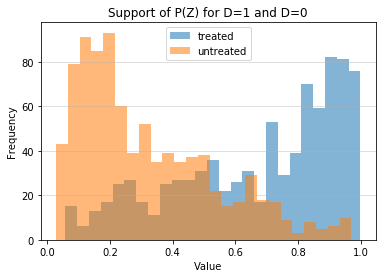

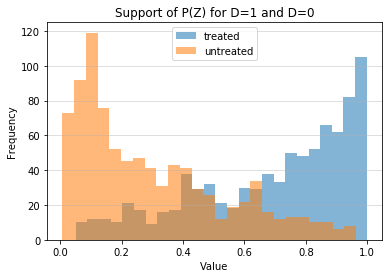

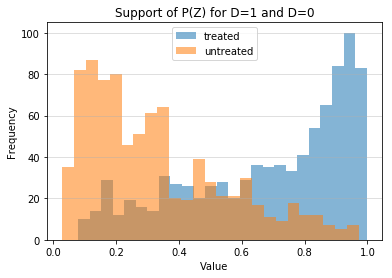

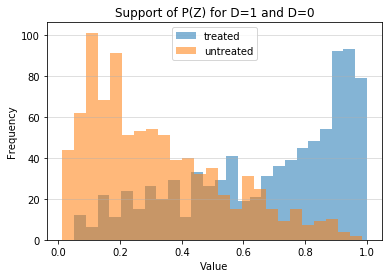

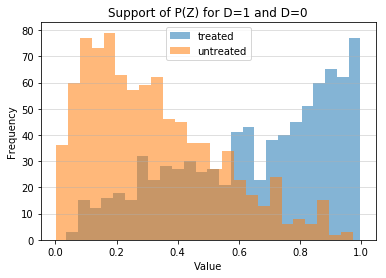

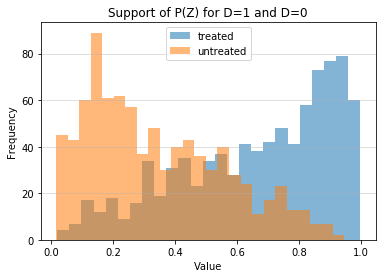

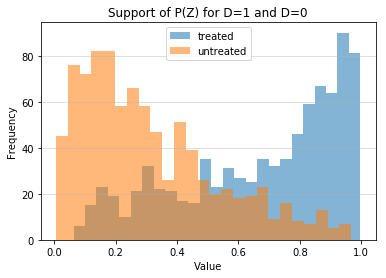

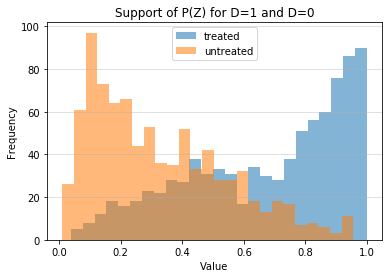

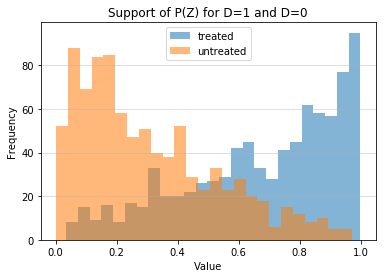

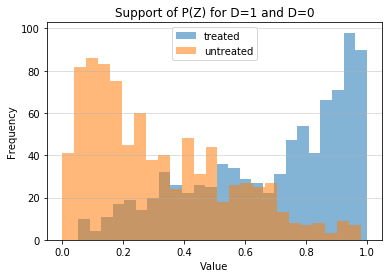

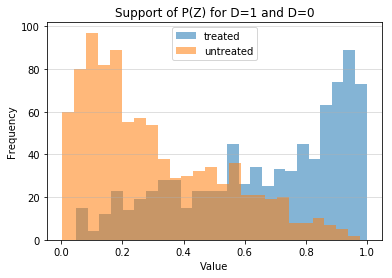

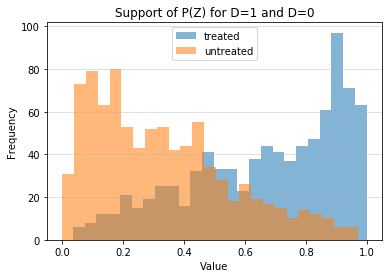

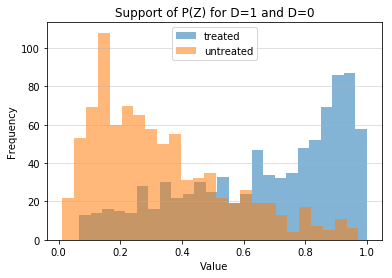

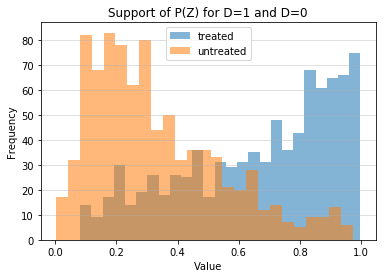

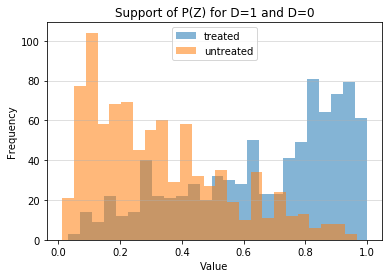

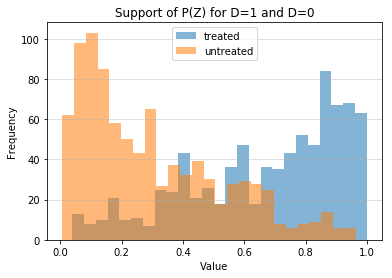

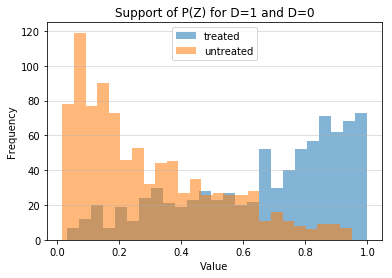

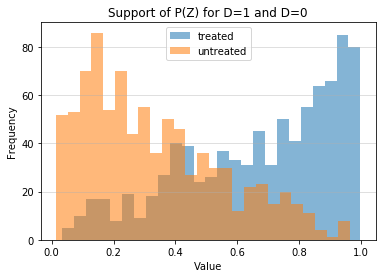

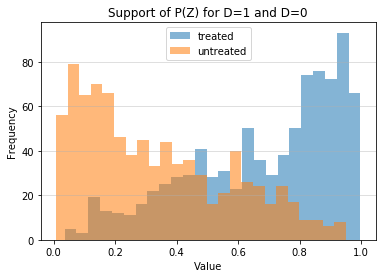

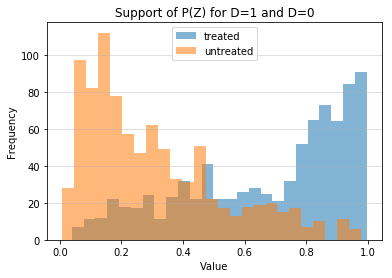

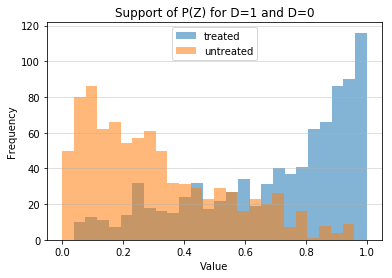

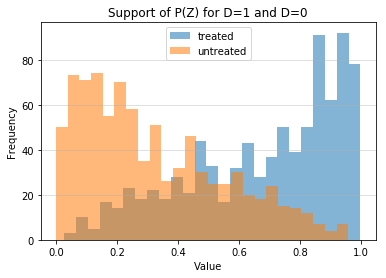

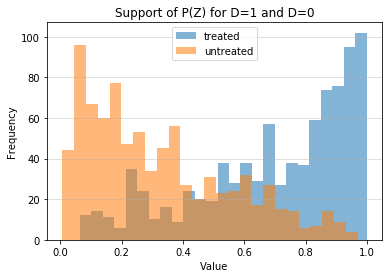

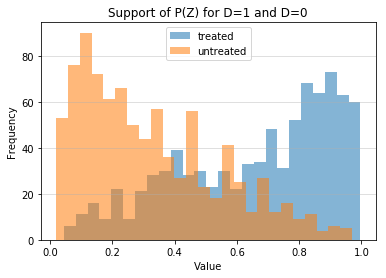

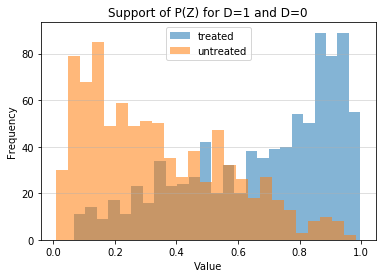

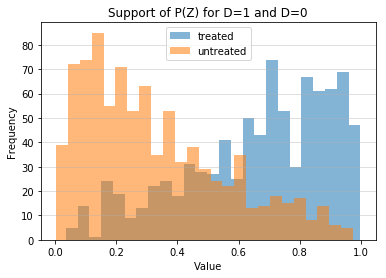

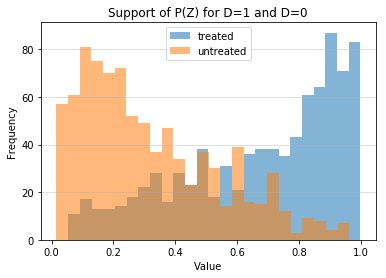

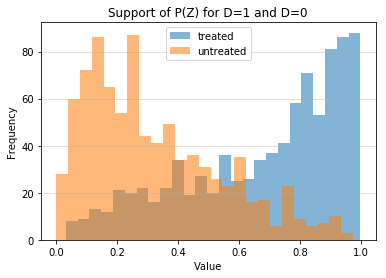

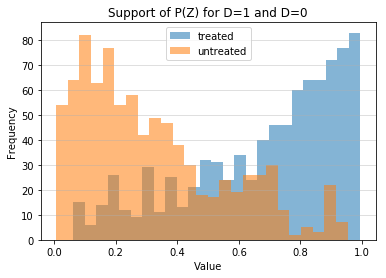

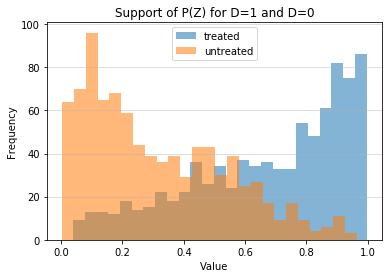

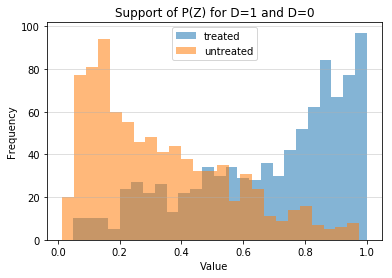

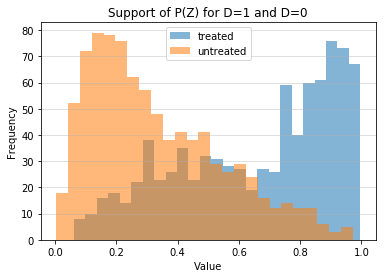

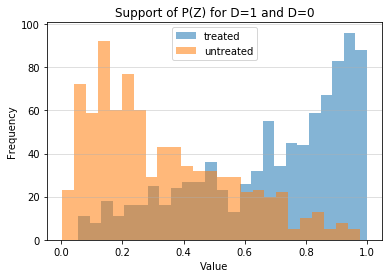

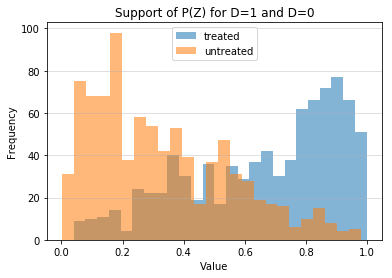

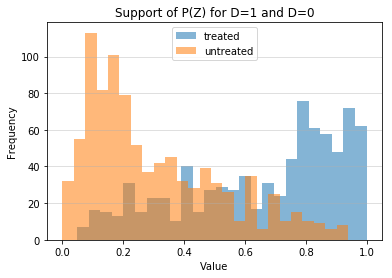

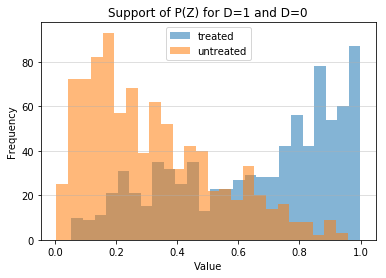

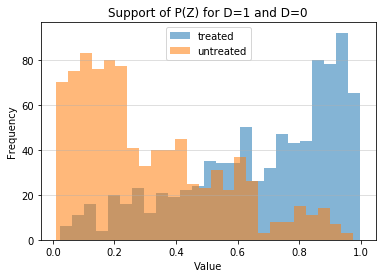

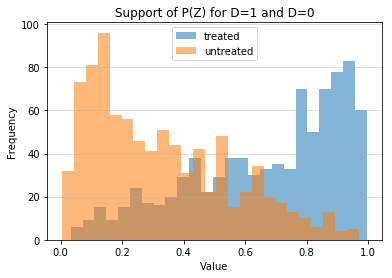

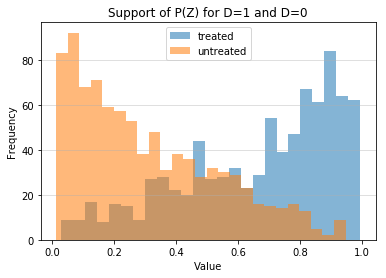

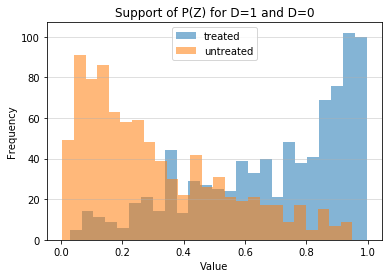

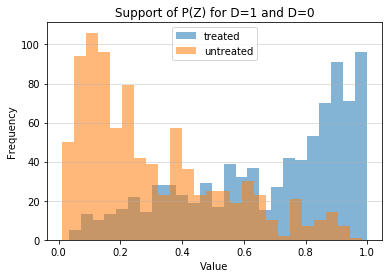

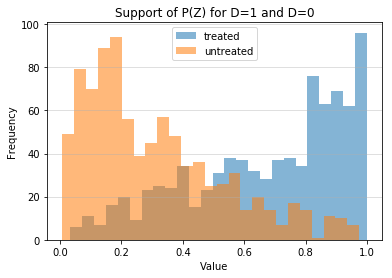

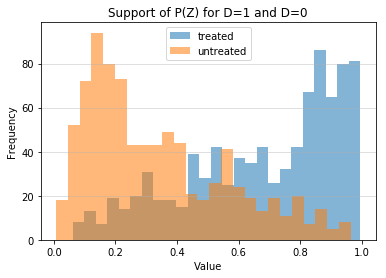

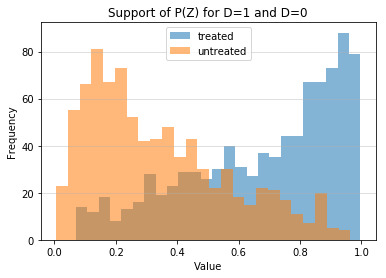

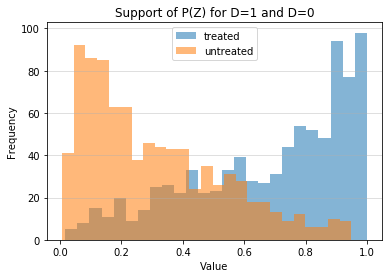

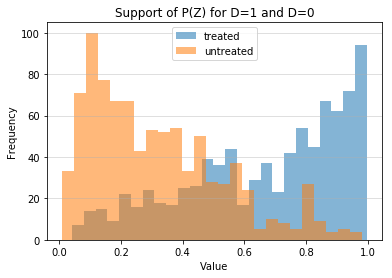

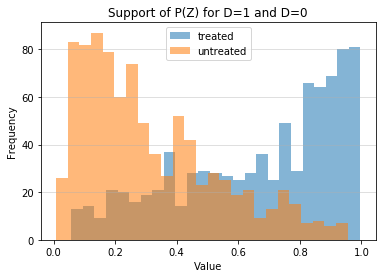

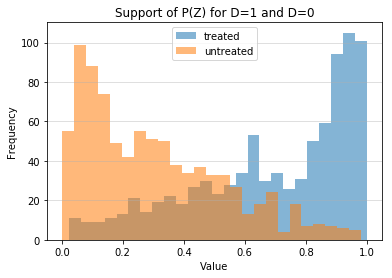

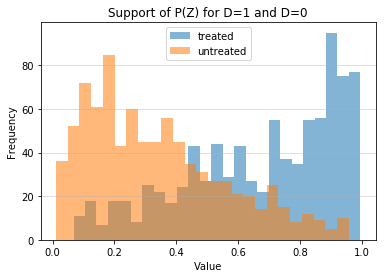

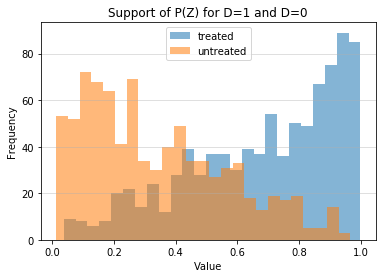

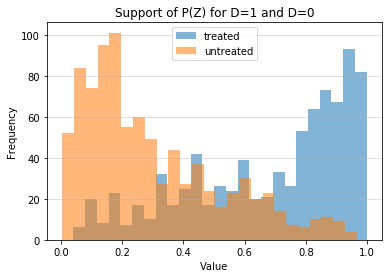

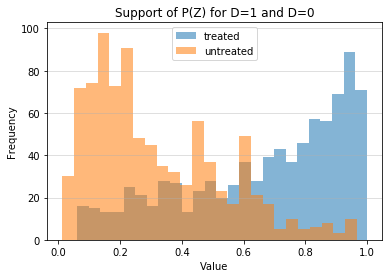

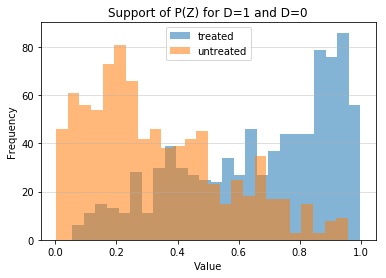

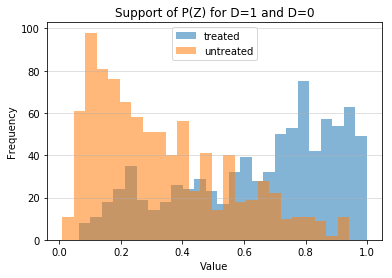

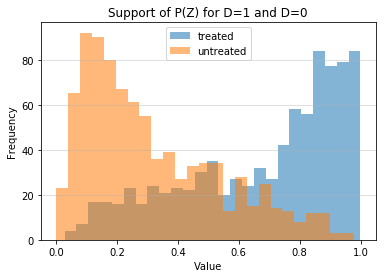

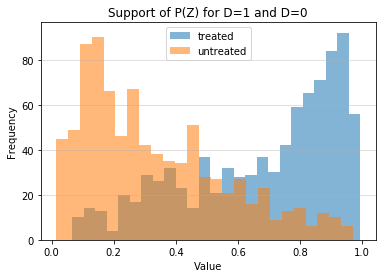

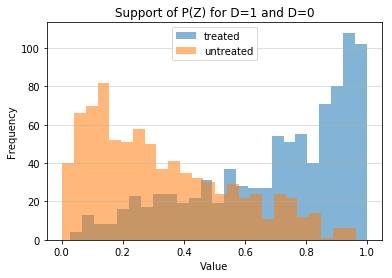

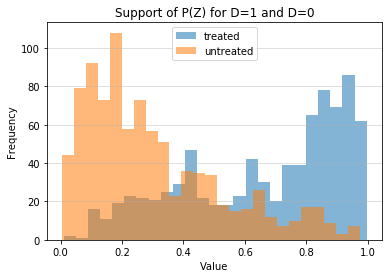

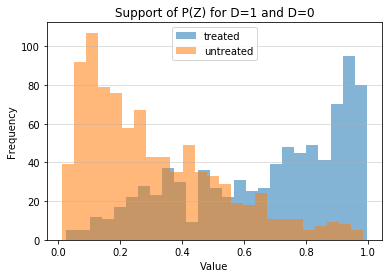

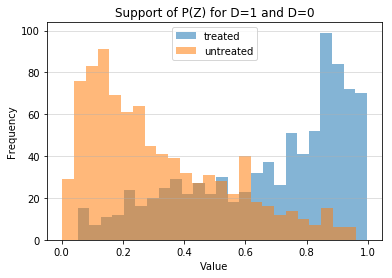

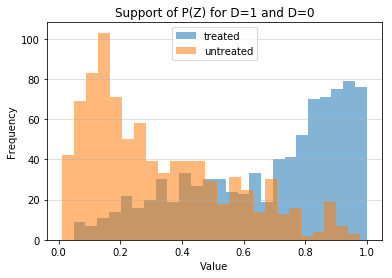

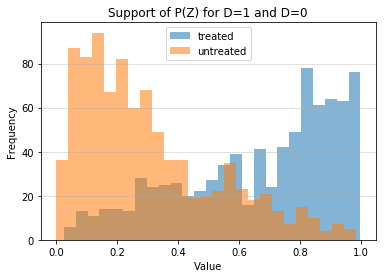

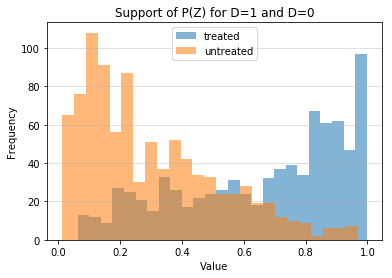

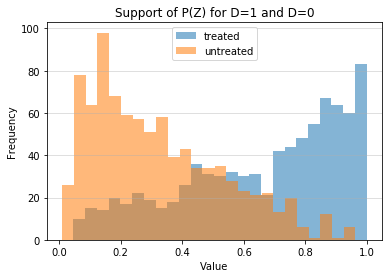

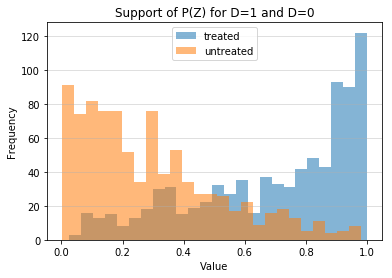

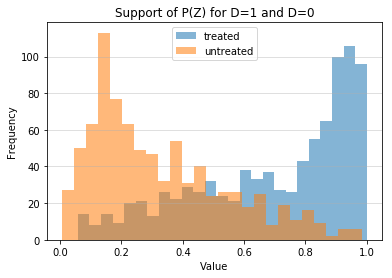

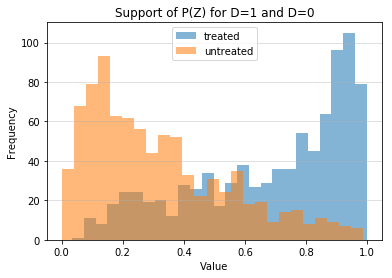

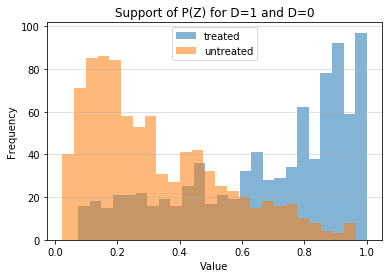

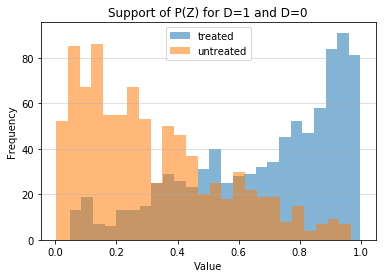

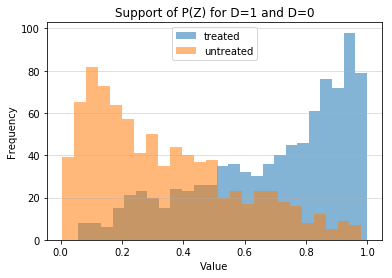

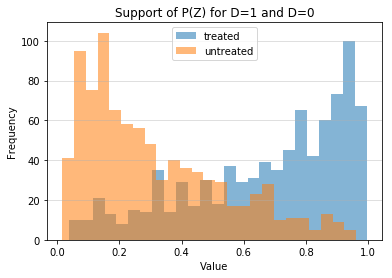

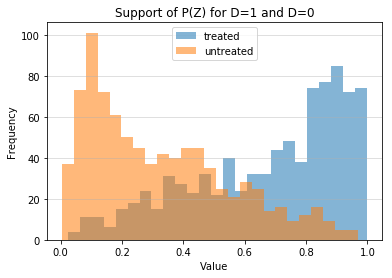

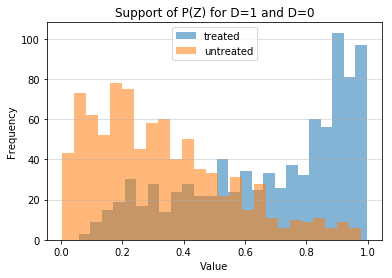

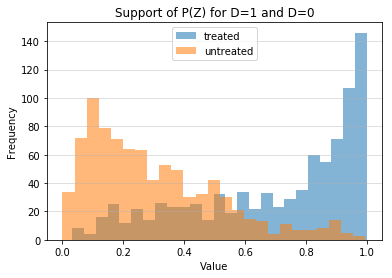

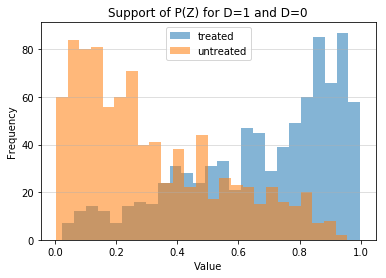

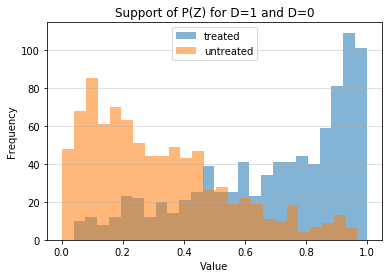

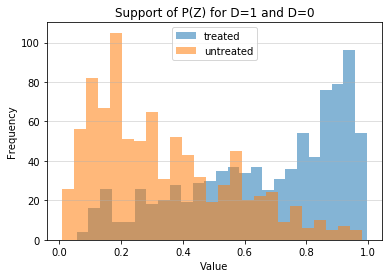

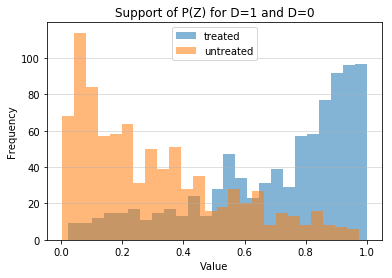

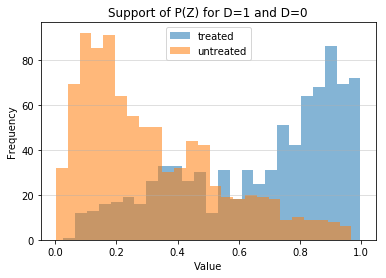

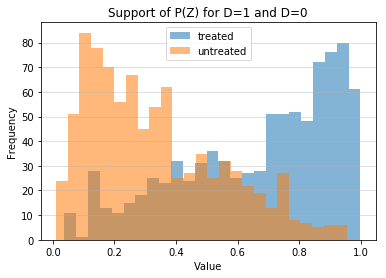

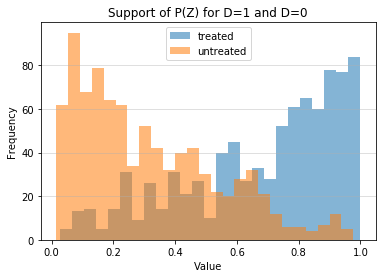

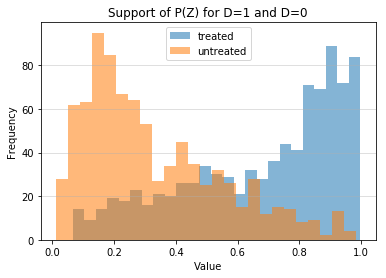

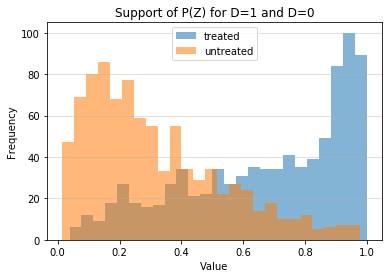

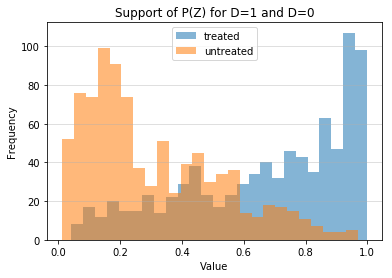

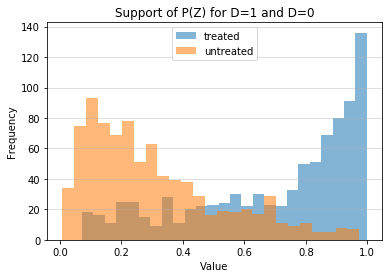

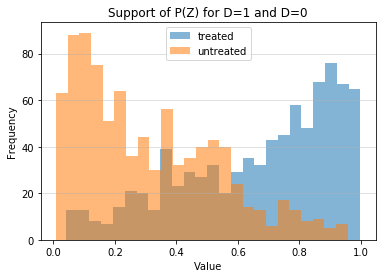

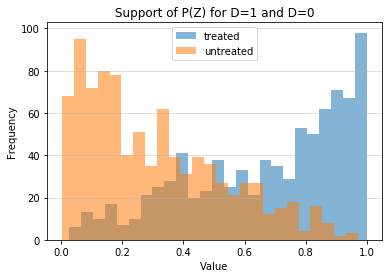

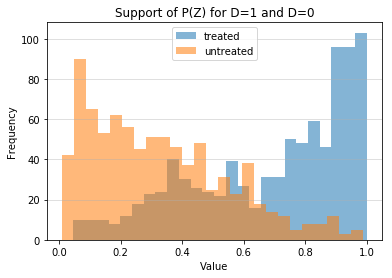

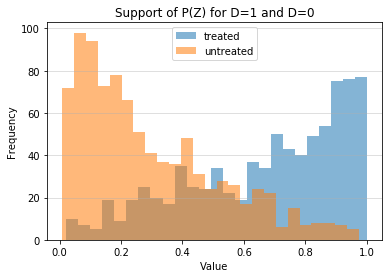

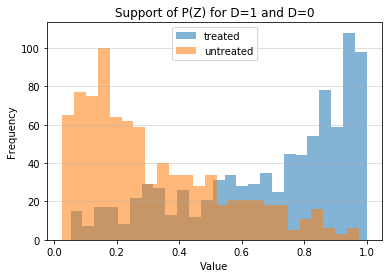

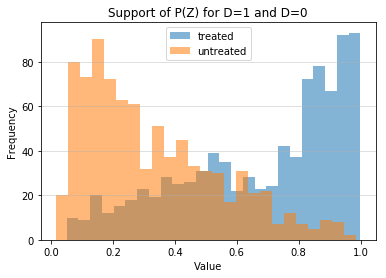

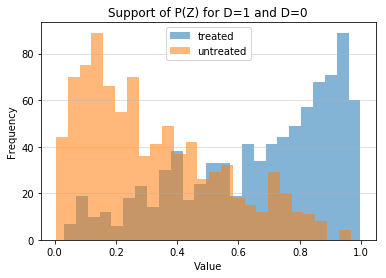

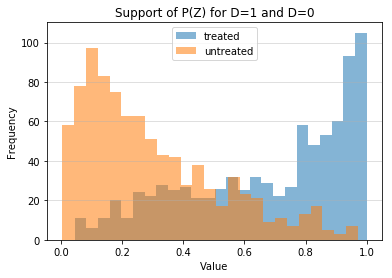

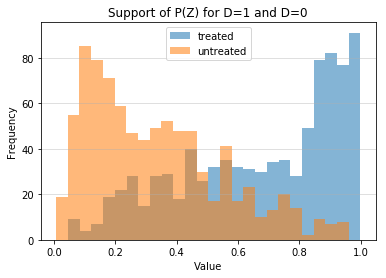

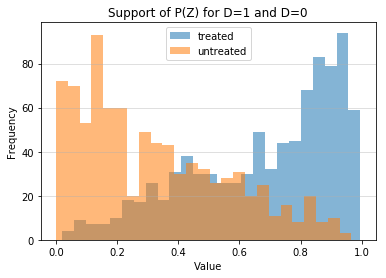

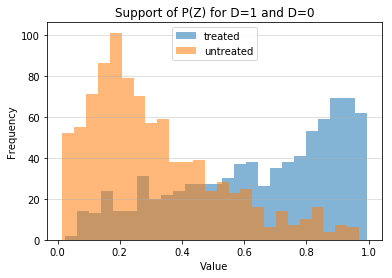

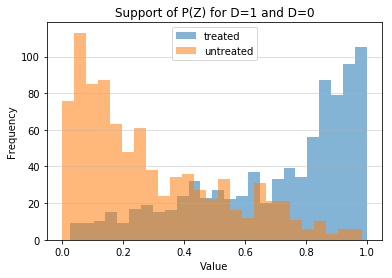

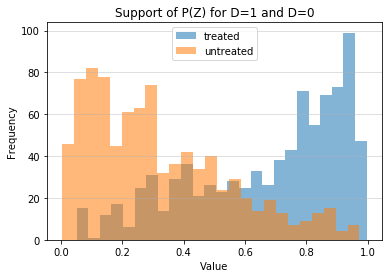

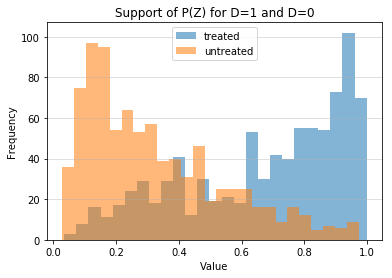

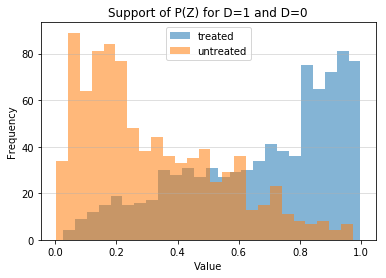

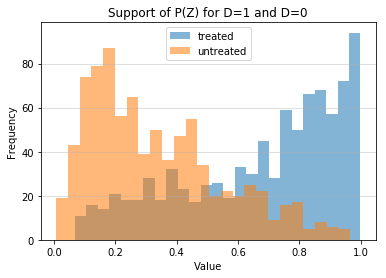

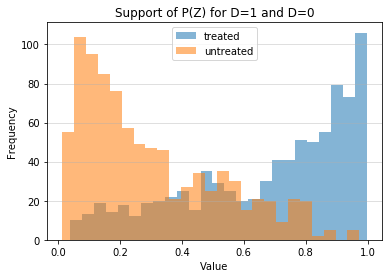

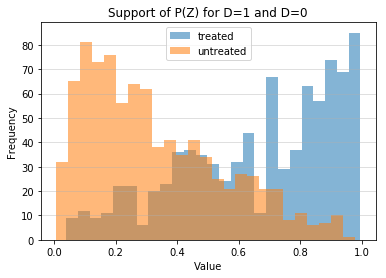

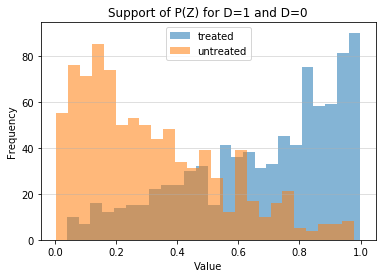

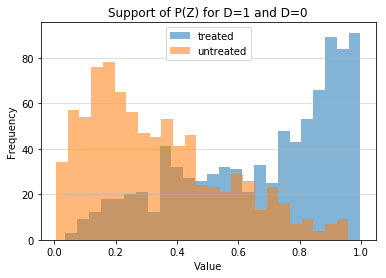

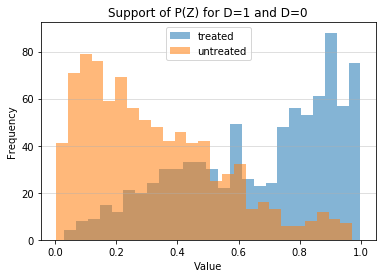

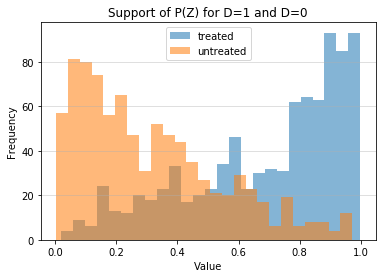

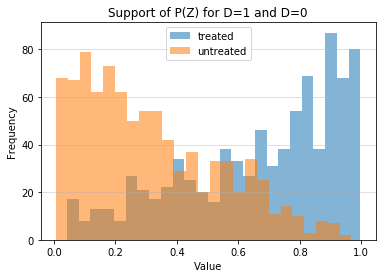

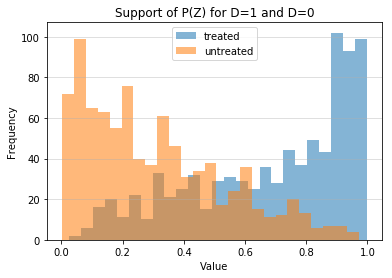

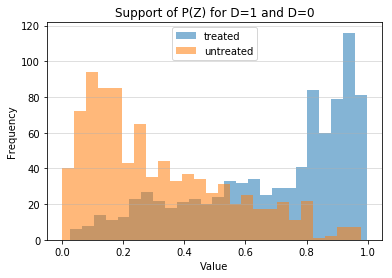

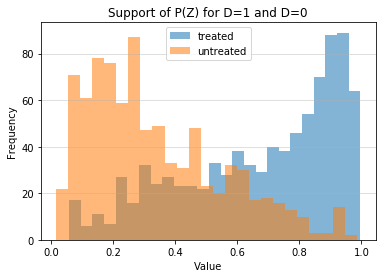

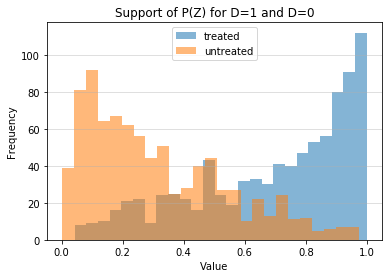

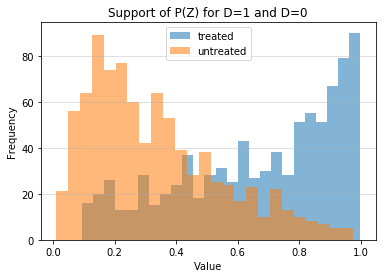

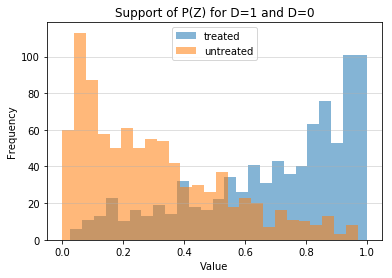

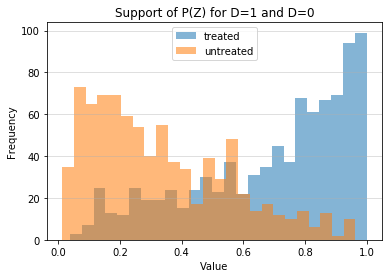

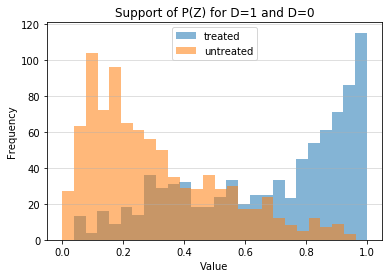

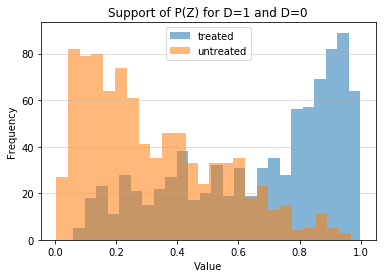

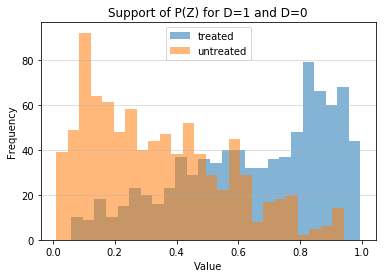

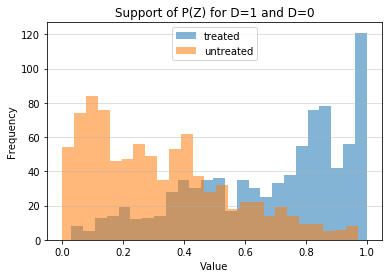

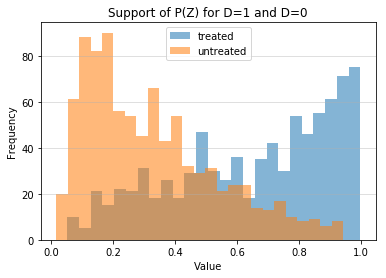

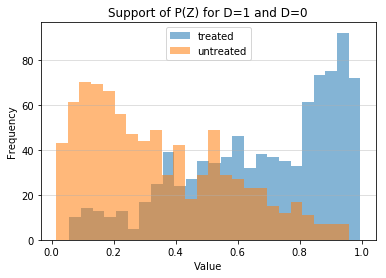

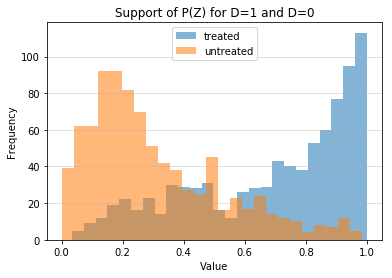

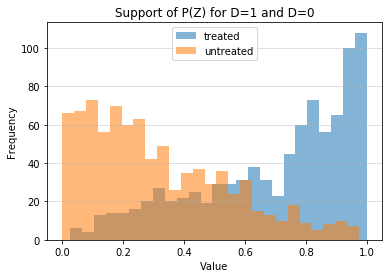

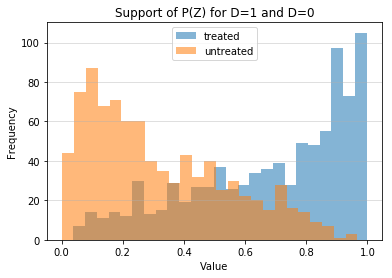

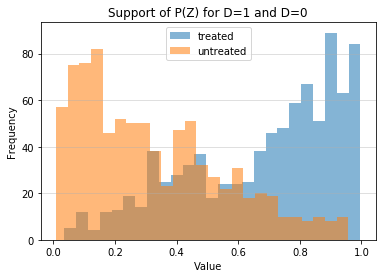

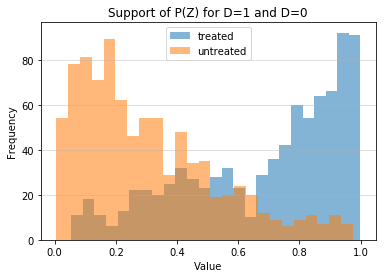

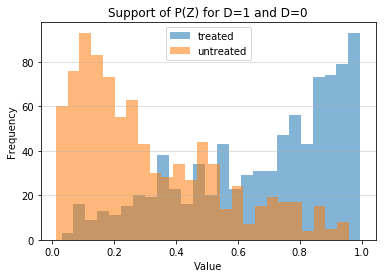

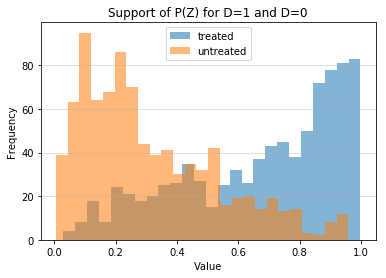

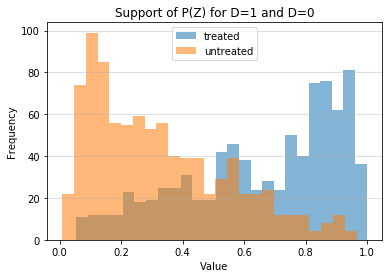

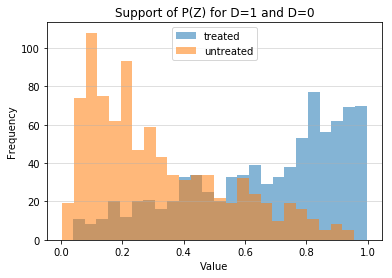

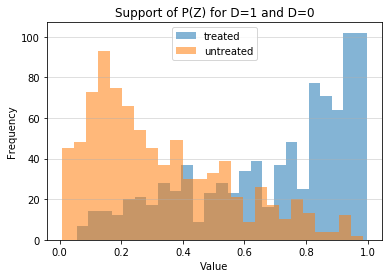

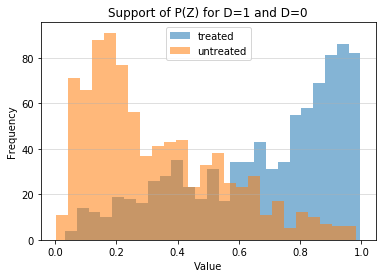

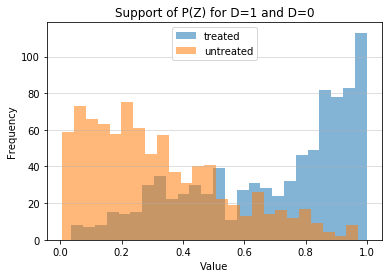

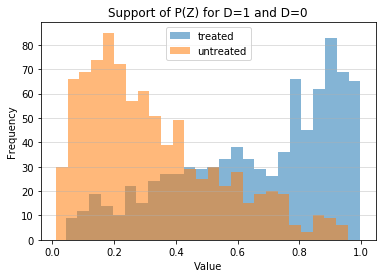

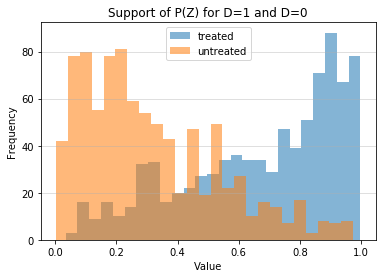

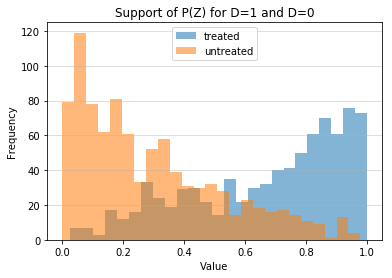

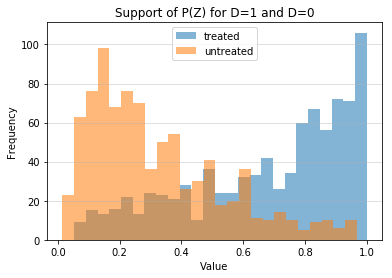

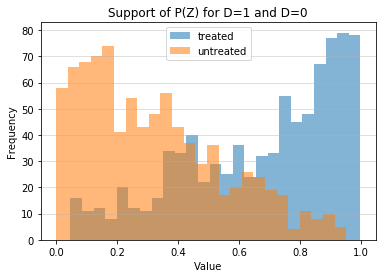

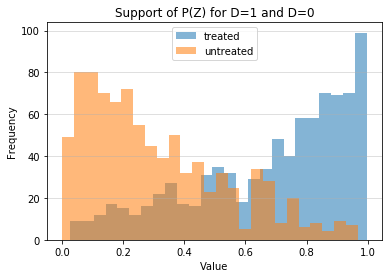

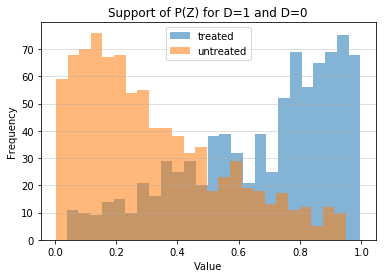

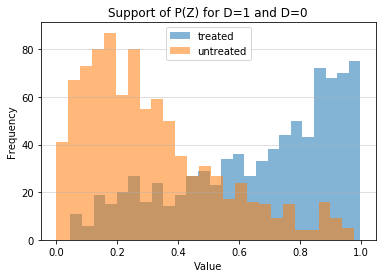

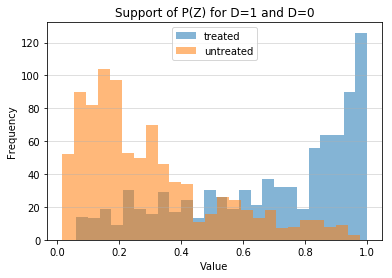

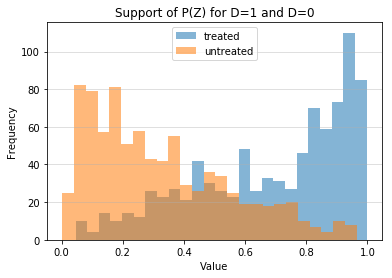

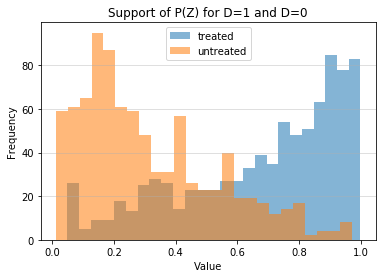

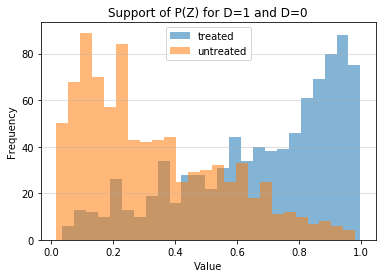

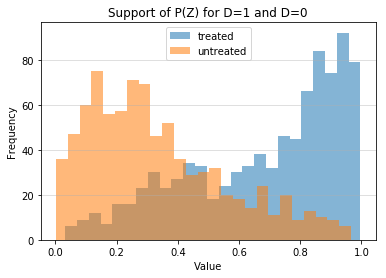

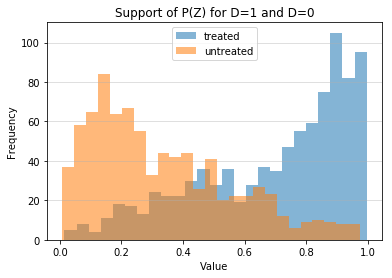

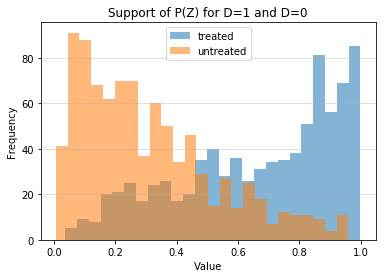

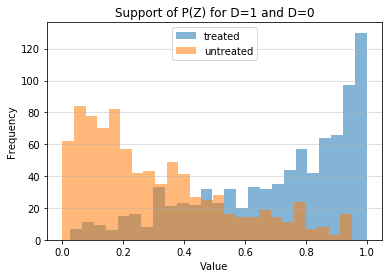

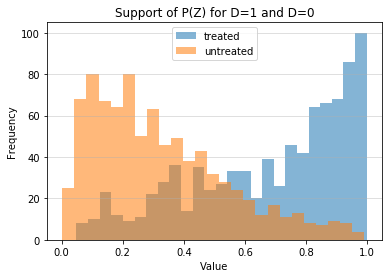

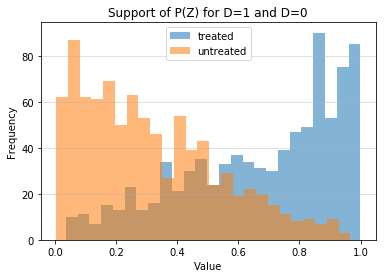

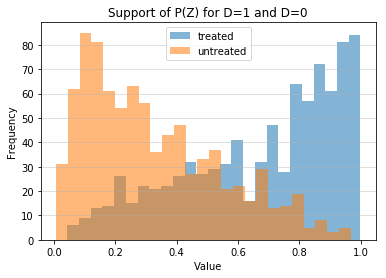

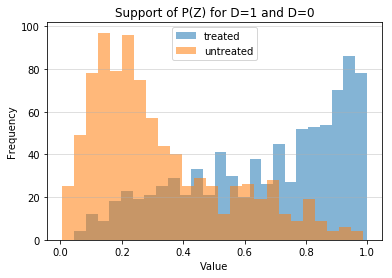

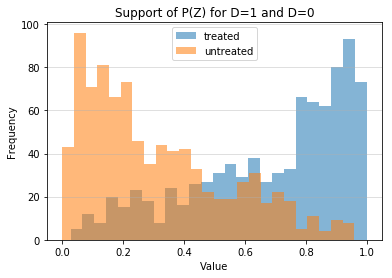

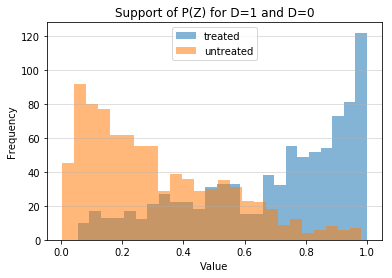

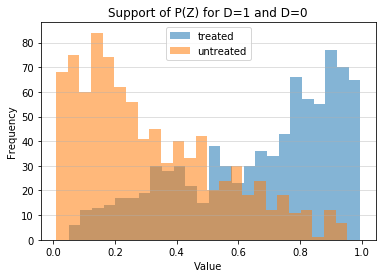

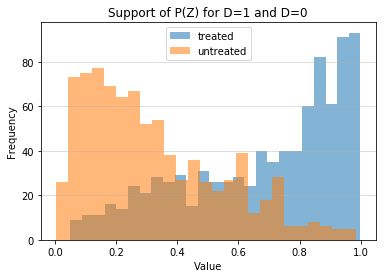

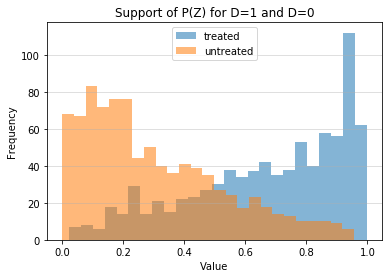

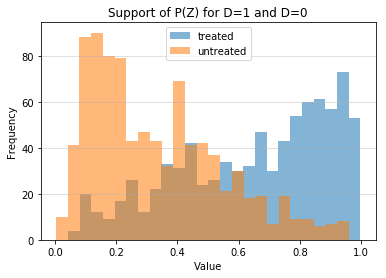

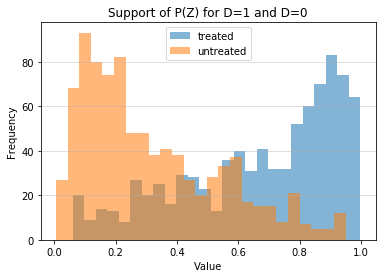

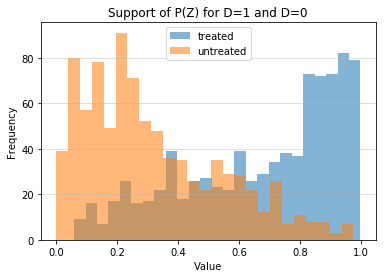

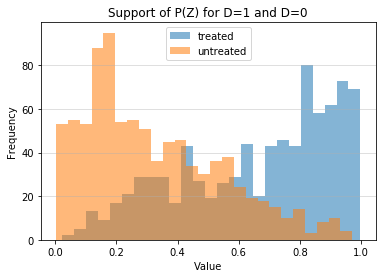

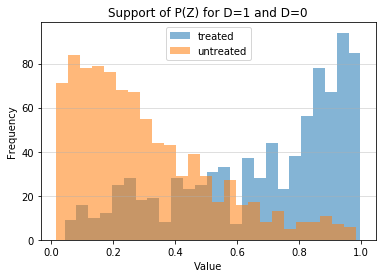

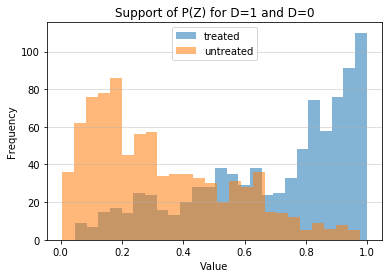

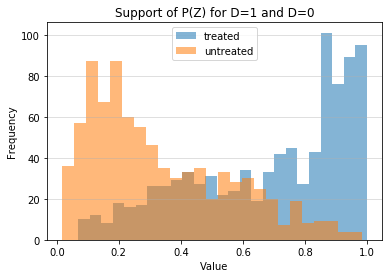

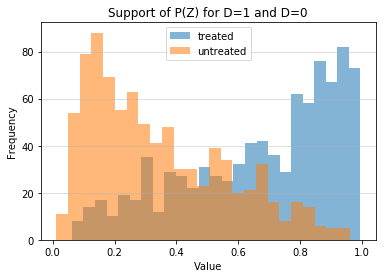

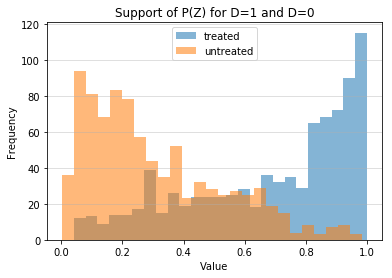

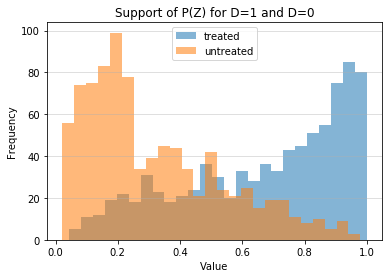

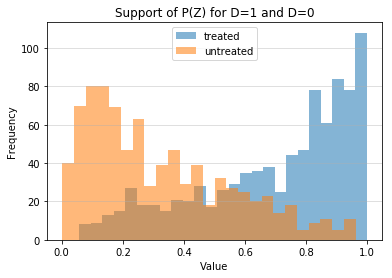

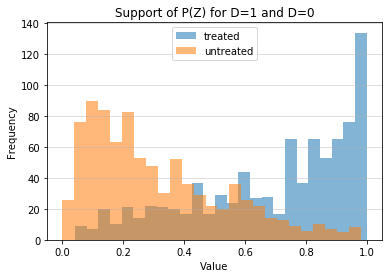

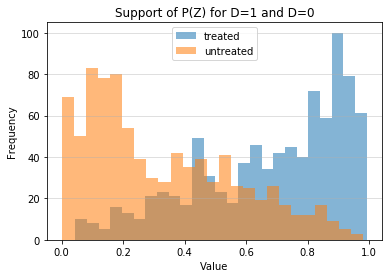

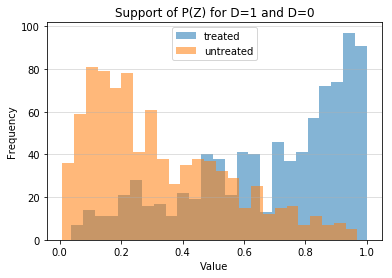

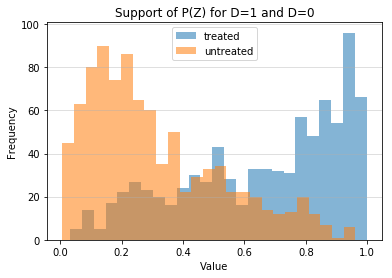

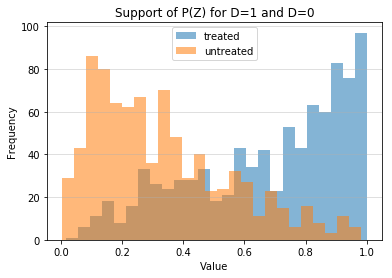

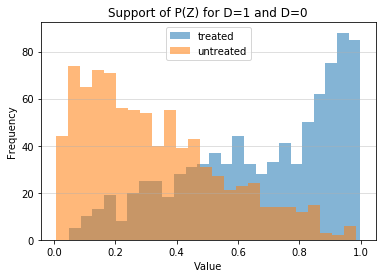

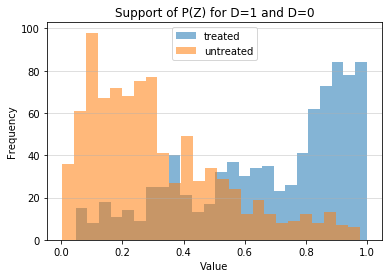

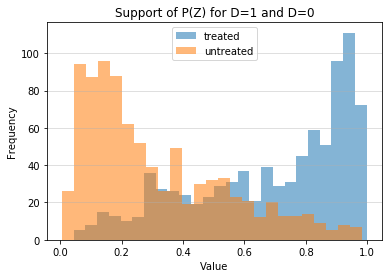

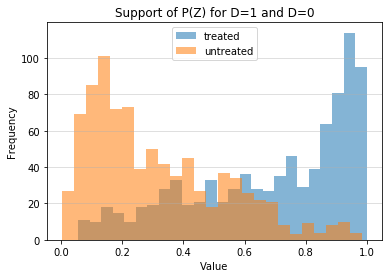

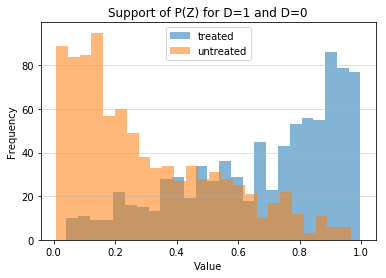

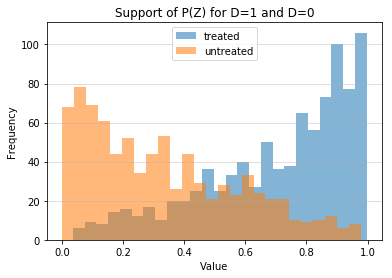

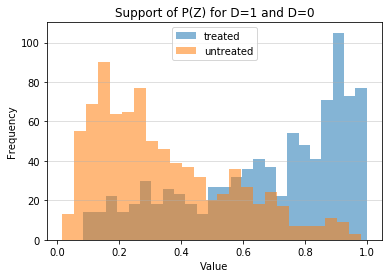

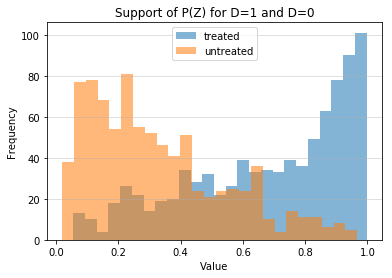

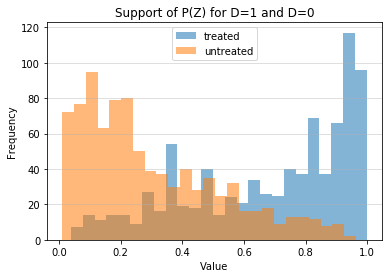

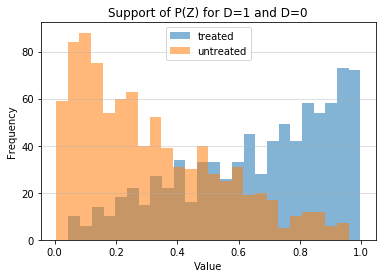

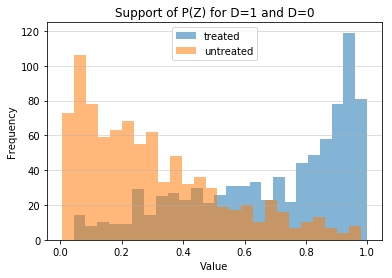

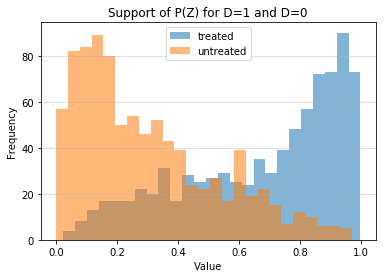

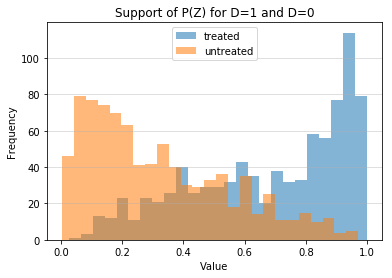

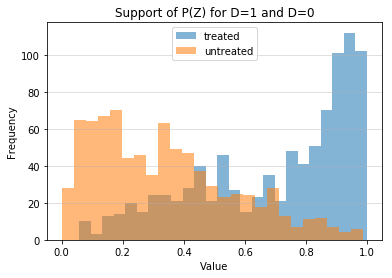

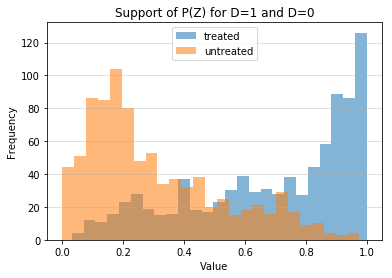

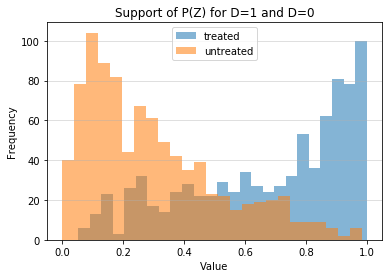

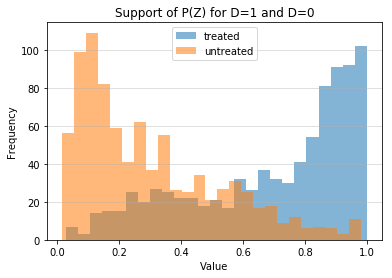

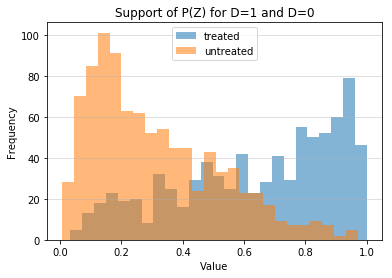

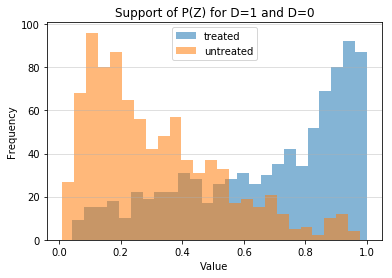

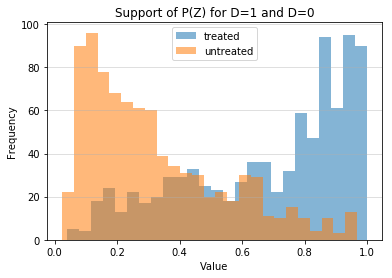

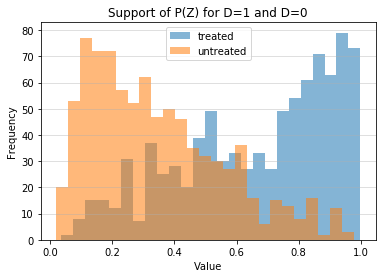

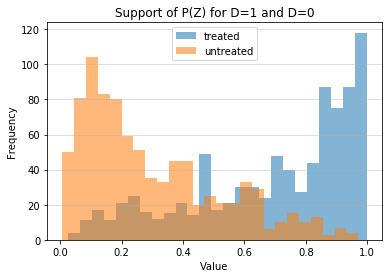

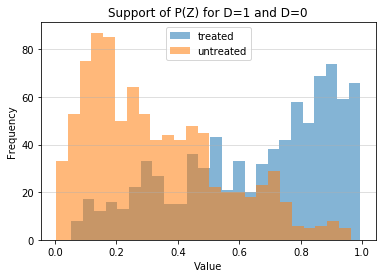

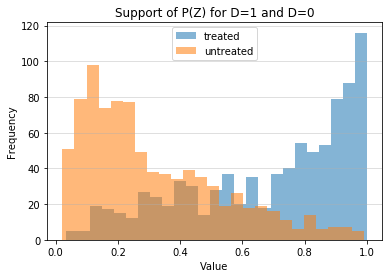

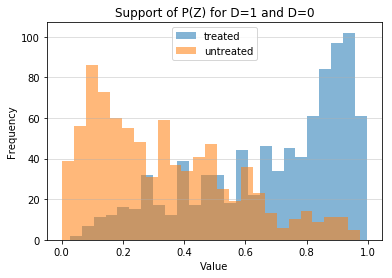

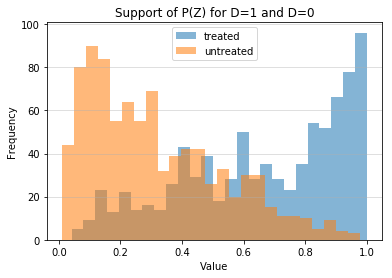

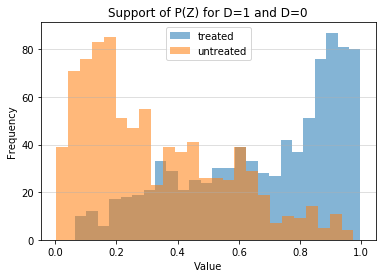

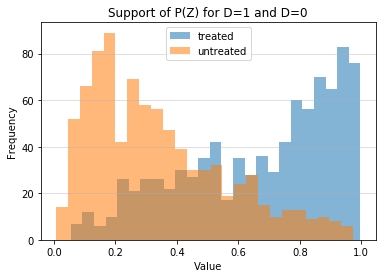

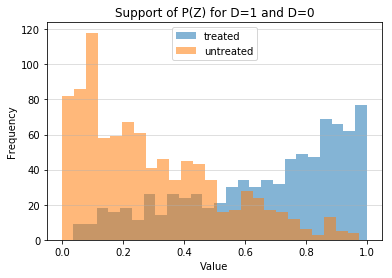

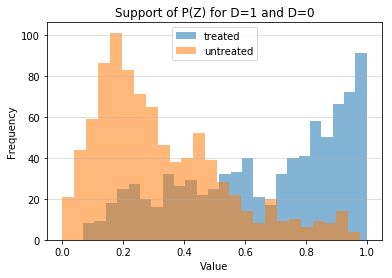

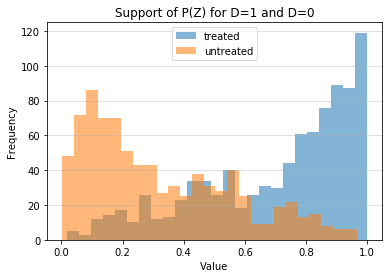

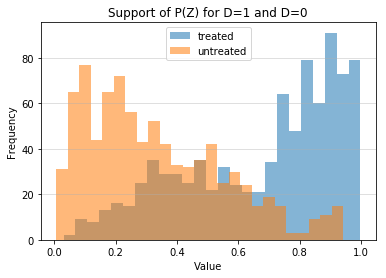

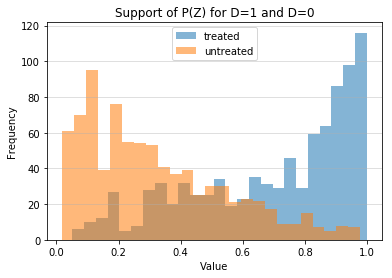

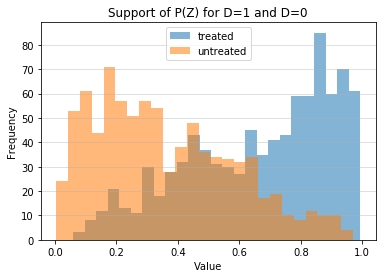

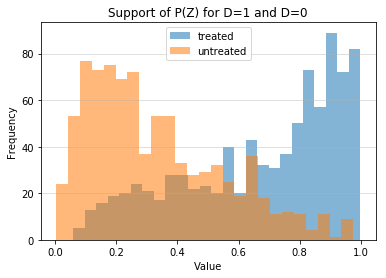

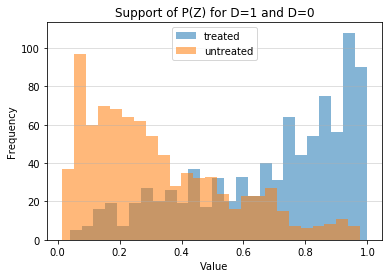

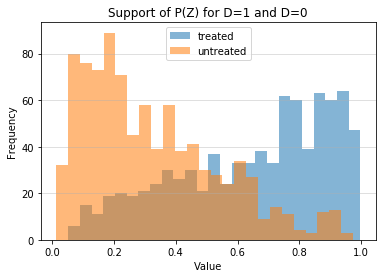

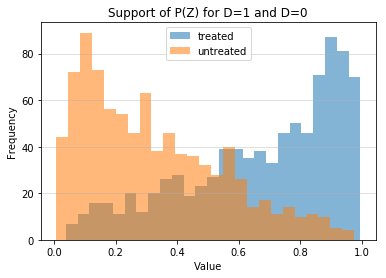

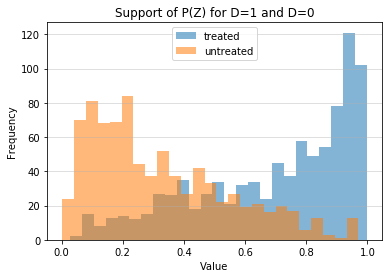

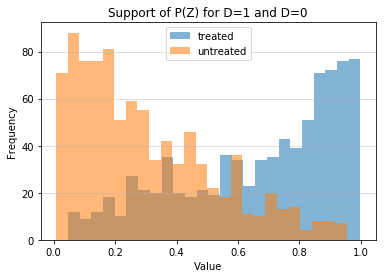

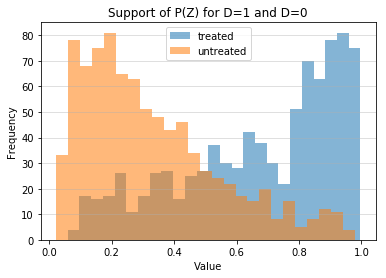

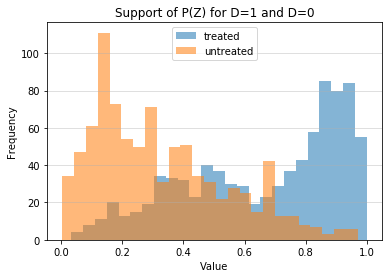

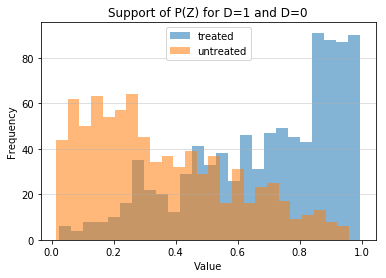

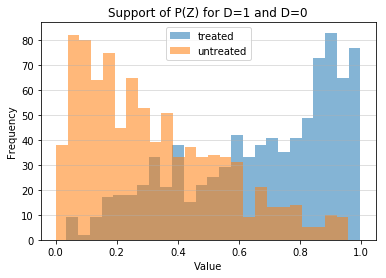

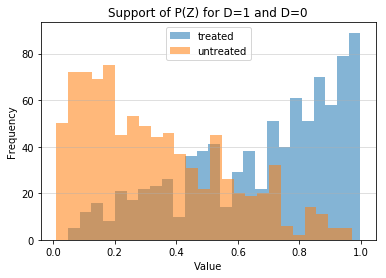

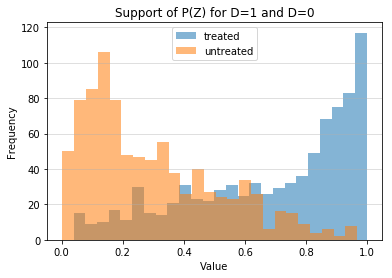

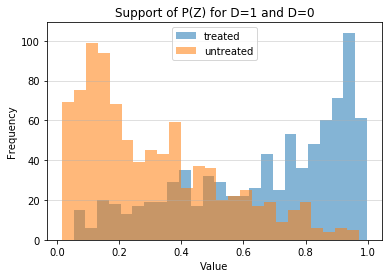

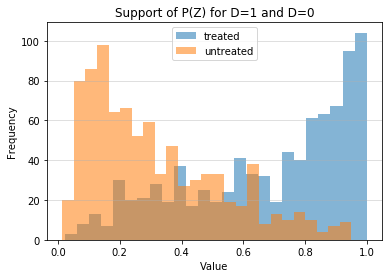

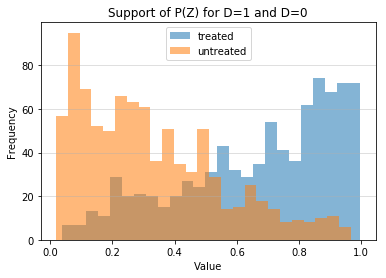

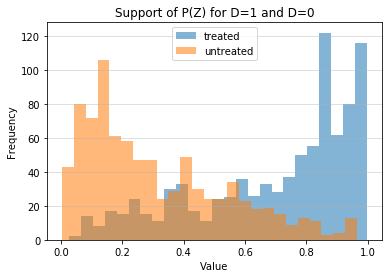

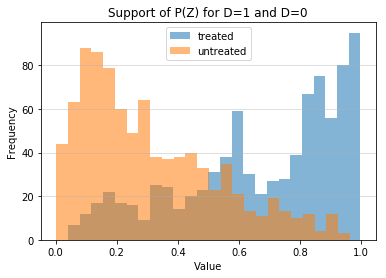

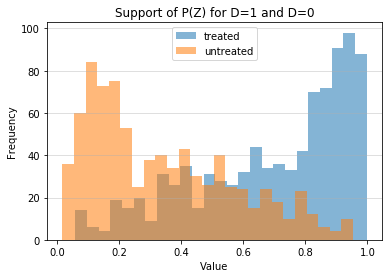

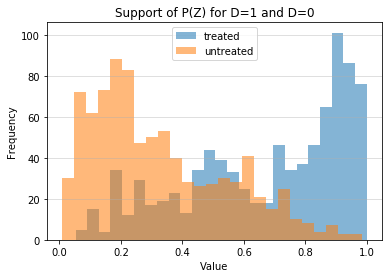

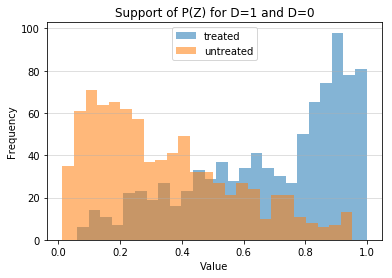

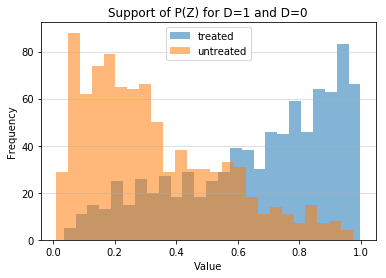

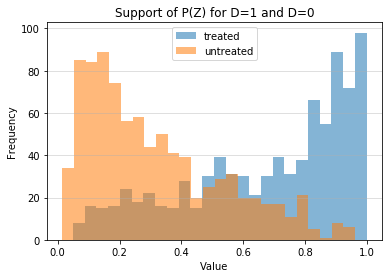

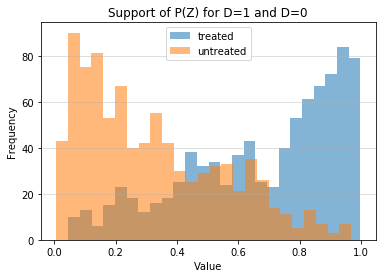

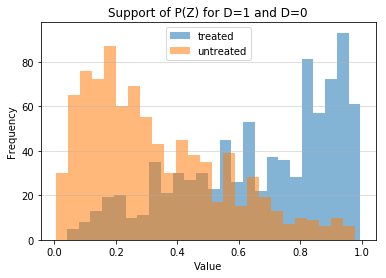

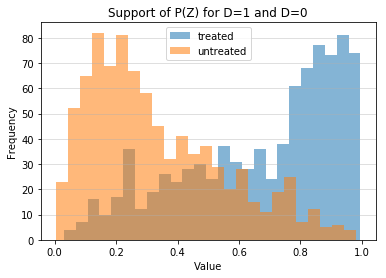

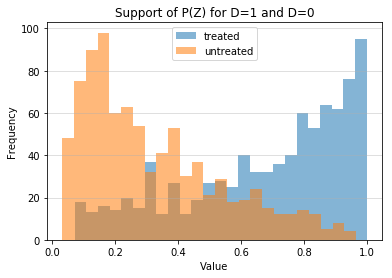

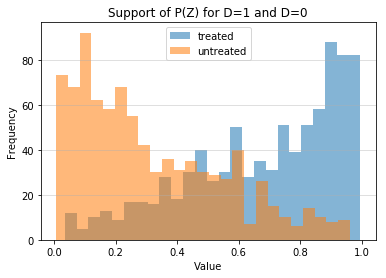

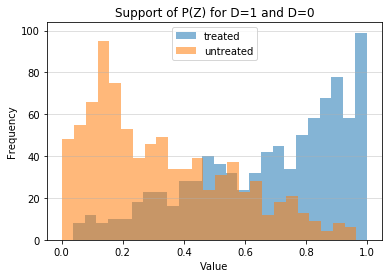

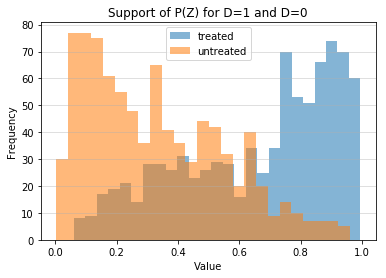

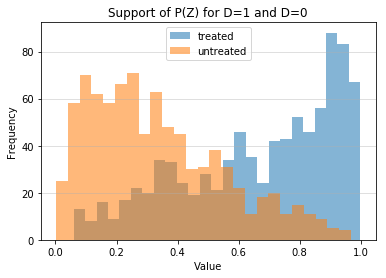

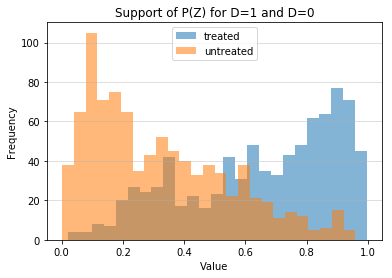

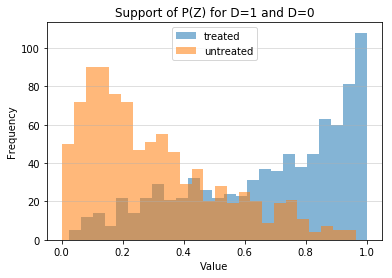

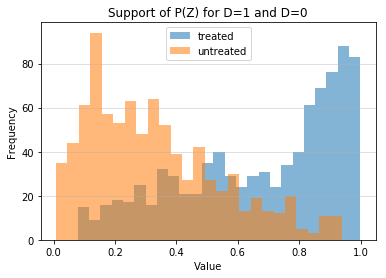

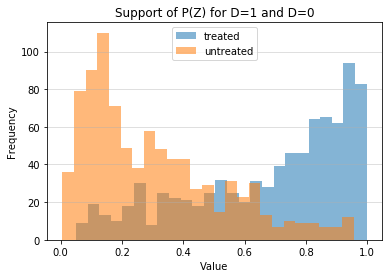

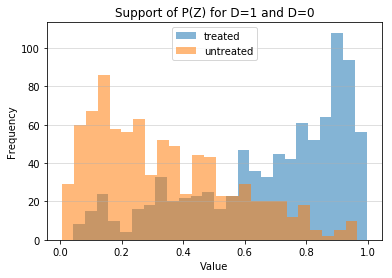

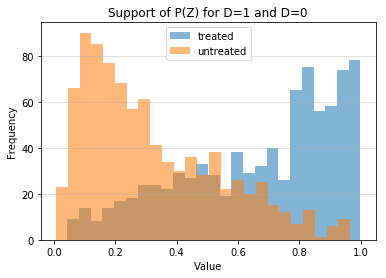

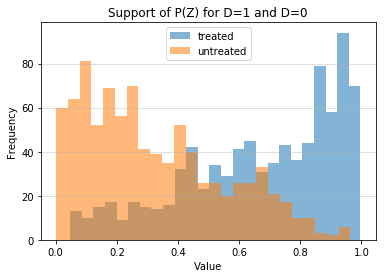

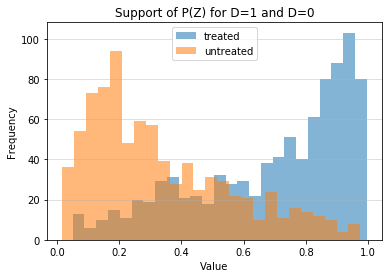

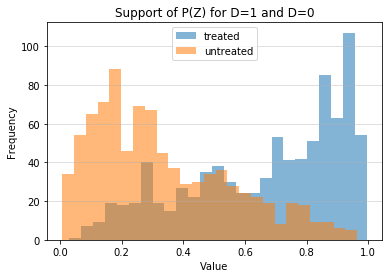

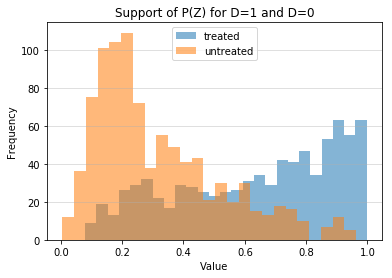

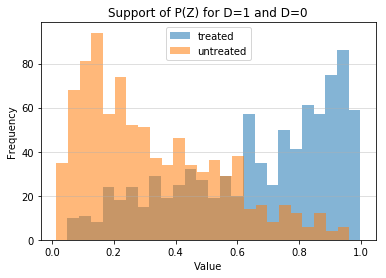

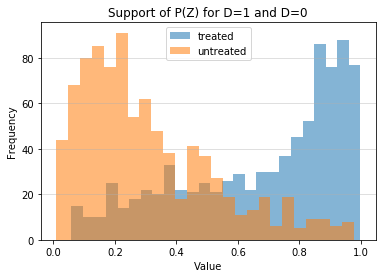

In [6]:
# Draw bootstraps and calculate MTE estimates.
nbootstraps = 250
mte_boot = bootstrap('semipar/files/replication.bootstrap.yml', nbootstraps)

Second, estimate the standard error of $\hat{\theta}^{MTE}$, denoted by $\widehat{\mathbf{se}}_B$, separately for each gridpoint $u_D$:

$$ \widehat{\mathbf{se}}_B = \frac{1}{B-1} \sum_{b = 1}^{B}{\{ \hat{\theta}}^{MTE}(b) \ - \ \hat{\theta}^{MTE}(\cdot)    \}^2 $$

where $\hat{\theta}^{MTE}(\cdot)$ is the replicated *MTE* of the baseline data set.

In [7]:
mte_boot = mte_boot / 4

# Get standard error of MTE at each gridpoint u_D
mte_boot_std = np.std(mte_boot, axis=1)

# Compute 90 percent confidence intervals
con_u = mte_4 + norm.ppf(0.95) * mte_boot_std
con_d = mte_4 - norm.ppf(0.95) * mte_boot_std

In [8]:
# import original results
mte_ = pd.read_csv('semipar/data/mte_semipar_original.csv')

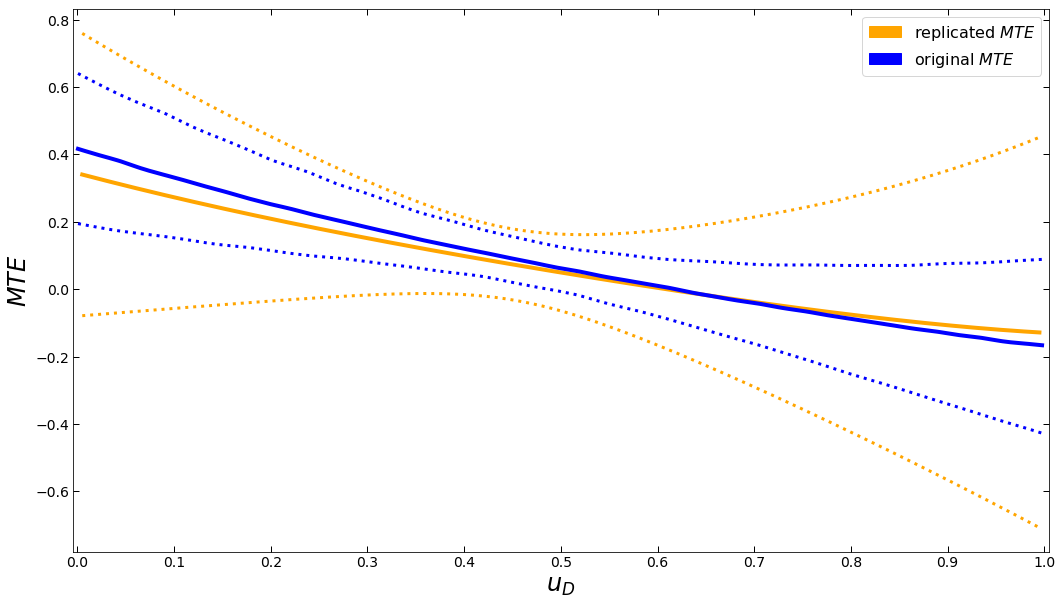

In [10]:
# Plot
ax = plt.figure(figsize=(17.5, 10)).add_subplot(111)

ax.set_ylabel(r"$MTE$", fontsize=24)
ax.set_xlabel("$u_D$", fontsize=24)
ax.tick_params(axis="both" ,direction='in', length=6, width=1, grid_alpha=0.25, labelsize=14)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks(np.arange(0, 1.1, step=0.1))
ax.yaxis.set_ticks(np.arange(-1.8, 0.9, step=0.2))

# Plot replicated curves
ax.plot(quantiles, mte_4, label="replicated $MTE$", color="orange", linewidth=4)
ax.plot(quantiles, con_u, color="orange", linestyle=":", linewidth=3)
ax.plot(quantiles, con_d, color="orange", linestyle=":", linewidth=3)

# Plot original curve
ax.plot(mte_['quantiles'], mte_['mte'], label="$original MTE$", color="blue", linewidth=4)
ax.plot(mte_['quantiles'], mte_['con_u'], color="blue", linestyle=":", linewidth=3)
ax.plot(mte_['quantiles'], mte_['con_d'], color="blue", linestyle=":", linewidth=3)

#ax.set_ylim([-0.51, 0.71])
ax.set_xlim([-0.005, 1.005])

blue_patch = mpatches.Patch(color="orange", label="replicated $MTE$")
orange_patch = mpatches.Patch(color="blue", label="original $MTE$")
plt.legend(handles=[blue_patch, orange_patch], prop={"size": 16})
plt.show()

People with the highest returns to education (those who have low unobserved resistance $u_D$
) are more likely to go to college. Note that the returns vary considerably with $u_D$
. Low $u_D$ students have returns of up to 40% per year of college, whereas high $u_D$
 people, who would loose from attending college, have returns of approximately - 15%.

The magnitude of total heterogeneity is probably even higher, as the _MTE_ depicts the average gain of college attendance _at the mean values of X_, <br> i.e. $\bar{x} (\beta_1 - \beta_0)$. Accounting for variation in $X$, i.e. conditioning on $X (\beta_1 - \beta_0)$, we observe returns as high as 64% and as low as -57%.

Note that the 90 percent confidence bands of the replicated _MTE_ are wider. This is due to the use of a mock data set which merges personal and local variables randomly. In particular, combined with the utilization of techniques, this makes the semiparametric replication more sensitive than a parametric normal specification.